In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy import stats
from collections import OrderedDict

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA 
from statsmodels.sandbox.stats.multicomp import multipletests 

from __init__ import *
import snmcseq_utils
from snmcseq_utils import create_logger 
from snmcseq_utils import plot_tsne_values
from snmcseq_utils import plot_tsne_labels
from snmcseq_utils import tsne_and_boxplot
from CEMBA_update_mysql import connect_sql
from CEMBA_update_mysql import gene_id_to_table_name as id2table
from CEMBA_init_ensemble_v2 import pull_genebody_info

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
import importlib
importlib.reload(snmcseq_utils)

<module 'snmcseq_utils' from '/cndd/fangming/CEMBA/snmcseq_dev/snmcseq_utils.py'>

In [3]:
log = create_logger()
engine = connect_sql(DATABASE)

ens = 'Ens7'
context = 'CH'

ens_path = os.path.join(PATH_ENSEMBLES, ens)
ens_genelevel_path = os.path.join(ens_path, 'gene_level')

In [4]:
cell_types = ['mDL-1', 'mDL-2', 'mDL-3', 'mL2/3', 'mL4', 'mL5-1', 'mL5-2', 'mL5-3',
       'mL5-4', 'mL6-1', 'mL6-2', 'mL6-3', 'mNdnf-1', 'mNdnf-2', 'mPv',
       'mSst-1', 'mSst-2', 'mSst-3', 'mVip', 'unlabeled']

cell_classes = ['Ex']*12 + ['In']*7 + ['Glia'] 
df_cell_class = pd.DataFrame()
df_cell_class['cell_type'] = cell_types
df_cell_class['cell_class'] = cell_classes
df_cell_class = df_cell_class.set_index('cell_type')
df_cell_class.head()

cell_class
cell_type           
mDL-1             Ex
mDL-2             Ex
mDL-3             Ex
mL2/3             Ex
mL4               Ex

In [5]:
tsne_cols = ['tsne_x_mCHmCG_ndim2_perp30', 'tsne_y_mCHmCG_ndim2_perp30']
cluster_col = 'cluster_mCHmCG_lv_npc50_k30'
annot_col = 'annotation_mCHmCG_lv_npc50_k30'

sql = 'SELECT * FROM cells JOIN {} ON cells.cell_id = {}.cell_id'.format(ens, ens)
df_info = pd.read_sql(sql, engine, index_col='cell_name')
# mark none as unlabeled
df_info[annot_col] = [annot if annot else 'unlabeled' for annot in df_info[annot_col]]
df_info = pd.merge(df_info, df_cell_class, left_on=annot_col, right_index=True)
print(df_info.shape)
df_info.head()

sql = 'SELECT * FROM genes'
df_gene = pd.read_sql(sql, engine, index_col='gene_id')
# back compatible
df_gene['geneName'] = df_gene['gene_name']
df_gene.head()

(4029, 140)


gene_name    chr      start        end strand  \
gene_id                                                               
ENSMUSG00000000001.4      Gnai3   chr3  108107280  108146146      -   
ENSMUSG00000000003.15      Pbsn   chrX   77837901   77853623      -   
ENSMUSG00000000028.14     Cdc45  chr16   18780447   18811987      -   
ENSMUSG00000000031.16       H19   chr7  142575529  142578143      -   
ENSMUSG00000000037.16     Scml2   chrX  161117193  161258213      +   

                            gene_type geneName  
gene_id                                         
ENSMUSG00000000001.4   protein_coding    Gnai3  
ENSMUSG00000000003.15  protein_coding     Pbsn  
ENSMUSG00000000028.14  protein_coding    Cdc45  
ENSMUSG00000000031.16         lincRNA      H19  
ENSMUSG00000000037.16  protein_coding    Scml2

In [6]:
df_info['region'] = [dataset.split('_')[1] for dataset in df_info['dataset']]

# back-compatible
df_info['Biosample'] = df_info['region'].values
df_info['cluster_ID'] = df_info[cluster_col].values
df_info['cluster_annotation'] = df_info[annot_col].values
df_info['mCH/CH'] = df_info['global_mCH'].values


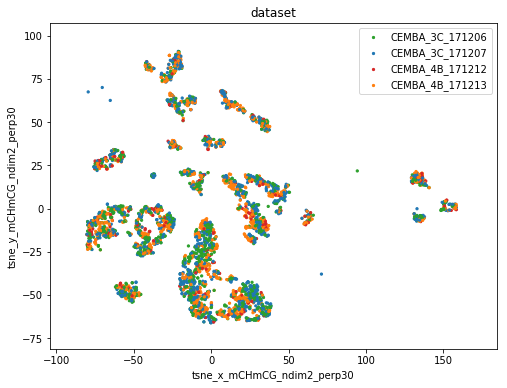

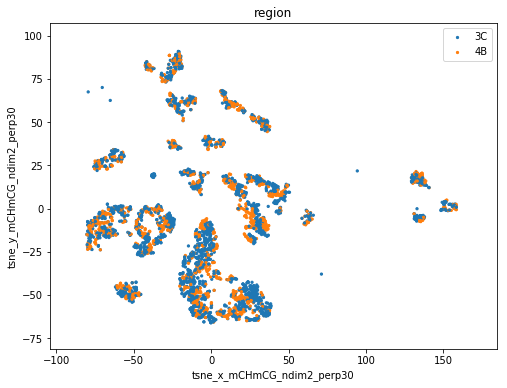

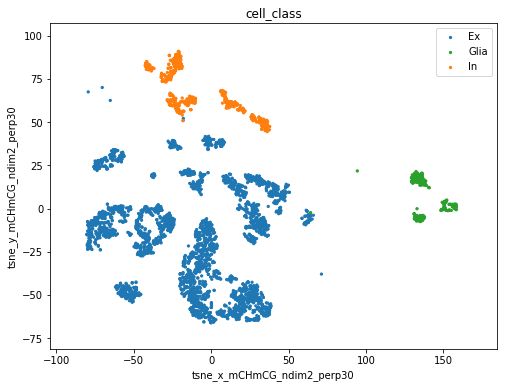

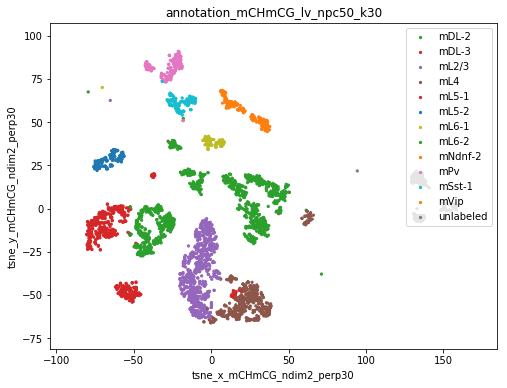

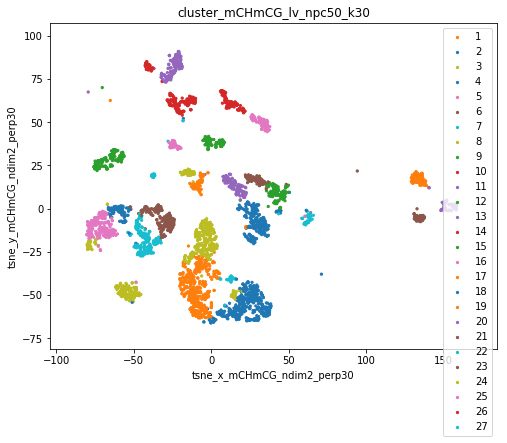

In [7]:
# plot tsne by clustering by datasat
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='dataset', s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='region', s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc='cell_class', s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc=annot_col, s=5)
plot_tsne_labels(df_info, tx=tsne_cols[0], ty=tsne_cols[1], tc=cluster_col, s=5)

In [8]:
# df_info['genebody_path'] = ['{}/{}/gene_level/genebody_{}.tsv.bgz'.format(PATH_DATASETS, dataset, cell_name) 
#                             for dataset, cell_name in zip(df_info.dataset, df_info.index)]
# pull_genebody_info(ens, ens_genelevel_path, df_info.index.tolist(), df_info['genebody_path'].tolist(), to_file=True)

In [9]:
mc_c_file = os.path.join(ens_path, 'gene_level/genebody_m{}_{}.tsv.bgz'.format(context, ens))
df = snmcseq_utils.read_genebody(mc_c_file, compression='gzip')
print(df.shape)
df.head()

(51772, 8058)


171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed_mc  \
gene_id                                                                                                       
ENSMUSG00000102693.1                                                  0                                       
ENSMUSG00000064842.1                                                  0                                       
ENSMUSG00000051951.5                                                  4                                       
ENSMUSG00000102851.1                                                  0                                       
ENSMUSG00000103377.1                                                  0                                       

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed_c  \
gene_id                                                                                                      
ENSMUSG00000102693.1                                                  0                                      
ENSMUSG00000064842.1                                                  0                                      
ENSMUSG00000051951.5                                                 68                                      
ENSMUSG00000102851.1                                                  0                                      
ENSMUSG00000103377.1                                                  0                                      

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A3_AD001_indexed_mc  \
gene_id                                                                                                      
ENSMUSG00000102693.1                                                  0                                      
ENSMUSG00000064842.1                                                  0                                      
ENSMUSG00000051951.5                                                101                                      
ENSMUSG00000102851.1                                                  2                                      
ENSMUSG00000103377.1                                                  1                                      

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A3_AD001_indexed_c  \
gene_id                                                                                                     
ENSMUSG00000102693.1                                                  0                                     
ENSMUSG00000064842.1                                                  0                                     
ENSMUSG00000051951.5                                               8065                                     
ENSMUSG00000102851.1                                                 43                                     
ENSMUSG00000103377.1                                                 86                                     

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD004_indexed_mc  \
gene_id                                                                                                      
ENSMUSG00000102693.1                                                  0                                      
ENSMUSG00000064842.1                                                  0                                      
ENSMUSG00000051951.5                                                 92                                      
ENSMUSG00000102851.1                                                  0                                      
ENSMUSG00000103377.1                                                  0                                      

                      171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G3_AD004_indexed_c  \
gene_id                                                   

In [10]:
df_mc = df.filter(regex='_mc')
df_c = df.filter(regex='_c')

df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns]
df_c.columns = [col[:-len('_c')] for col in df_c.columns]

print(df_mc.shape)
print(df_c.shape)


(51772, 4029)
(51772, 4029)


In [11]:
# remove low coverage gene

base_call_cutoff = 100 
sufficient_coverage_fraction = 0.94 
condition = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 


print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]
print(df_mcc.shape)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'


Matrix size before pruning... (51772, 8058)
Matrix size after pruning... (10867, 8058)
(10867, 4029)
Imputing data...


# End of preprocessing

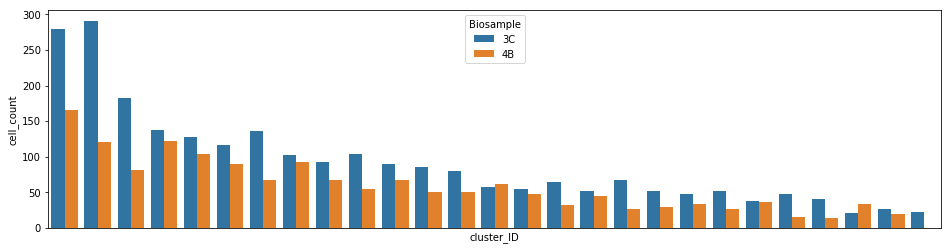

In [12]:
"""
For every cluster, plot biosample related quantities
"""
df_counts = df_info.groupby(['cluster_ID', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts.reset_index(level=['cluster_ID', 'Biosample'], inplace=True)
df_counts.columns = ['cluster_ID', 'Biosample', 'cell_count']

fig, ax = plt.subplots(figsize=(16, 4))
ax = sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts)
ax.set_xticks([])
plt.show()

In [13]:
df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new = pd.merge(df_counts, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new['cell_ratio'] = df_counts_new.cell_count/df_counts_new.tc_biosample


df_cluster_counts = df_info.groupby('cluster_ID').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new = pd.merge(df_counts_new, df_cluster_counts, left_on='cluster_ID', right_index=True)
df_counts_new['cell_ratio_cluster'] = df_counts_new.cell_ratio/df_counts_new.tc_cluster

print(df_counts_new.shape)
df_counts_new.head()

(53, 7)


cluster_ID Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0           1        3C         280          2472    0.113269         445   
1           1        4B         165          1557    0.105973         445   
2           2        3C         291          2472    0.117718         412   
3           2        4B         121          1557    0.077714         412   
4           3        3C         182          2472    0.073625         264   

   cell_ratio_cluster  
0            0.000255  
1            0.000238  
2            0.000286  
3            0.000189  
4            0.000279

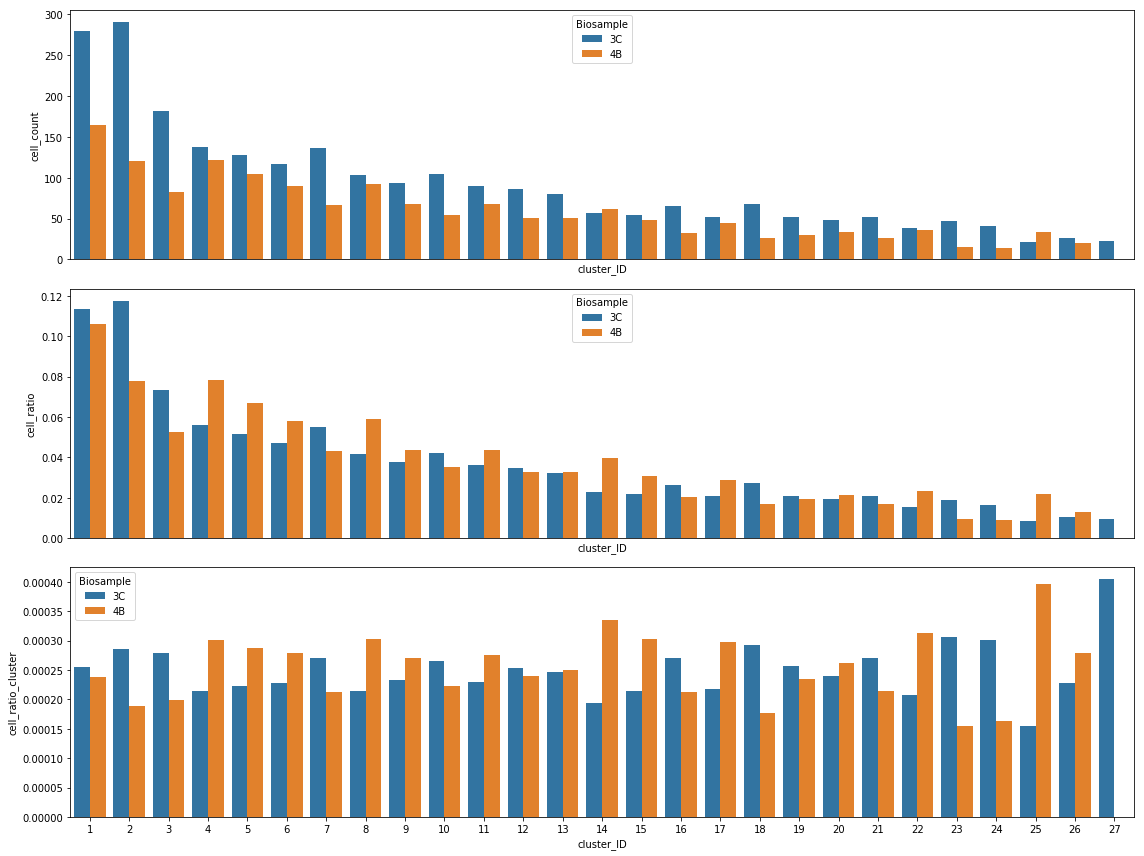

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_ID", y="cell_count", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_ID", y="cell_ratio", hue="Biosample", data=df_counts_new, ax=ax)
ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_ID", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new, ax=ax)
# ax.set_xticks([])
fig.tight_layout()
plt.show()

In [15]:
df_counts_2 = df_info.groupby(['cluster_annotation', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_2 = df_counts_2.reset_index(level=['cluster_annotation', 'Biosample'])
df_counts_2.columns = ['cluster_annotation', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_2 = pd.merge(df_counts_2, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_2['cell_ratio'] = df_counts_new_2.cell_count/df_counts_new_2.tc_biosample

df_cluster_counts = df_info.groupby('cluster_annotation').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_2 = pd.merge(df_counts_new_2, df_cluster_counts, left_on='cluster_annotation', right_index=True)
df_counts_new_2['cell_ratio_cluster'] = df_counts_new_2.cell_ratio/df_counts_new_2.tc_cluster

df_counts_new_2.head()

cluster_annotation Biosample  cell_count  tc_biosample  cell_ratio  \
0              mDL-2        3C         253          2472    0.102346   
1              mDL-2        4B         157          1557    0.100835   
2              mDL-3        3C          23          2472    0.009304   
3              mL2/3        3C         462          2472    0.186893   
4              mL2/3        4B         247          1557    0.158638   

   tc_cluster  cell_ratio_cluster  
0         410            0.000250  
1         410            0.000246  
2          23            0.000405  
3         709            0.000264  
4         709            0.000224

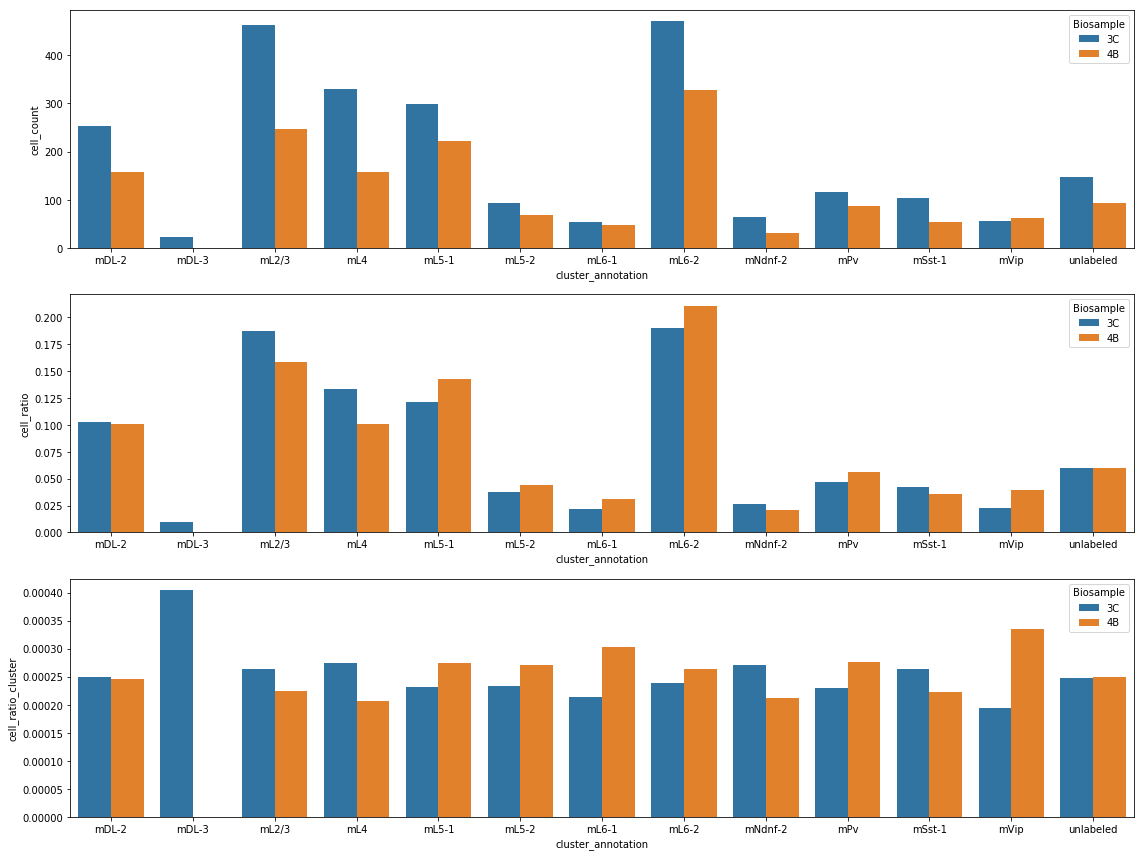

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cluster_annotation", y="cell_count", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cluster_annotation", y="cell_ratio", hue="Biosample", data=df_counts_new_2, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cluster_annotation", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_2, ax=ax)
fig.tight_layout()
plt.show()

In [17]:
df_counts_3 = df_info.groupby(['cell_class', 'Biosample']).count()['mCH/CH'].to_frame()
df_counts_3 = df_counts_3.reset_index(level=['cell_class', 'Biosample'])
df_counts_3.columns = ['cell_class', 'Biosample', 'cell_count']

df_sample_counts = df_info.groupby('Biosample').count()['mCH/CH'].to_frame()
df_sample_counts.columns = ['tc_biosample']
df_counts_new_3 = pd.merge(df_counts_3, df_sample_counts, left_on='Biosample', right_index=True)
df_counts_new_3['cell_ratio'] = df_counts_new_3.cell_count/df_counts_new_3.tc_biosample

df_cluster_counts = df_info.groupby('cell_class').count()['mCH/CH'].to_frame()
df_cluster_counts.columns = ['tc_cluster']
df_counts_new_3 = pd.merge(df_counts_new_3, df_cluster_counts, left_on='cell_class', right_index=True)
df_counts_new_3['cell_ratio_cluster'] = df_counts_new_3.cell_ratio/df_counts_new_3.tc_cluster

df_counts_new_3

cell_class Biosample  cell_count  tc_biosample  cell_ratio  tc_cluster  \
0         Ex        3C        1983          2472    0.802184        3210   
1         Ex        4B        1227          1557    0.788054        3210   
2       Glia        3C         147          2472    0.059466         240   
3       Glia        4B          93          1557    0.059730         240   
4         In        3C         342          2472    0.138350         579   
5         In        4B         237          1557    0.152216         579   

   cell_ratio_cluster  
0            0.000250  
1            0.000245  
2            0.000248  
3            0.000249  
4            0.000239  
5            0.000263

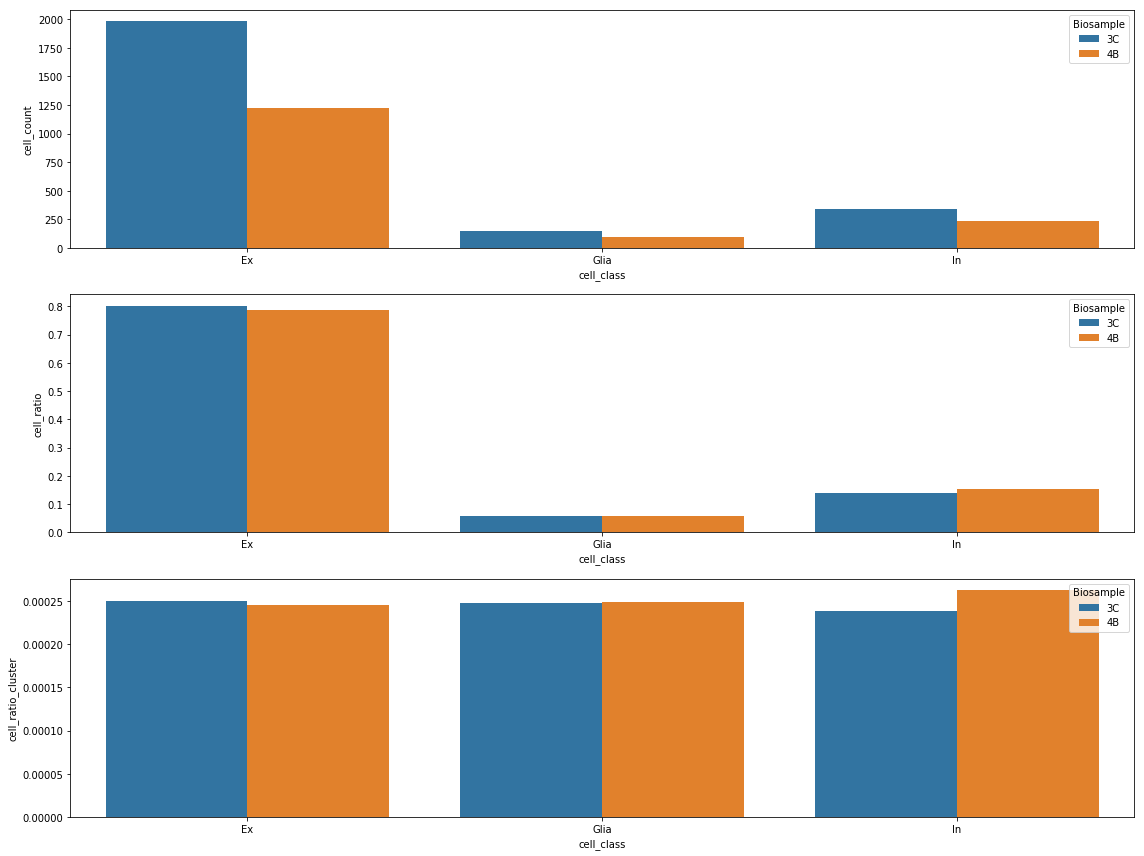

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))
ax = axs[0]
sns.barplot(x="cell_class", y="cell_count", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[1]
sns.barplot(x="cell_class", y="cell_ratio", hue="Biosample", data=df_counts_new_3, ax=ax)
# ax.set_xticks([])
ax = axs[2]
sns.barplot(x="cell_class", y="cell_ratio_cluster", hue="Biosample", data=df_counts_new_3, ax=ax)
fig.tight_layout()
plt.show()

# Analysis of variances

In [19]:
def sum_of_square(array):
    dev = array - np.mean(array)
    return np.dot(dev, dev)

# ANOVAs for each gene and each cluster

In [20]:
# ANOVAs for each gene

# sst ssw sr_n

df_sst = pd.DataFrame()
df_ssw = pd.DataFrame()
sr_n = pd.Series()
for idx, df_sub in df_info.groupby('cluster_annotation'):
    cells = df_sub.index.values
    SSt = df_mcc[cells+'_mcc'].apply(sum_of_square, axis=1)
    SSw = 0
    for idx2, df_sub2 in df_sub.groupby('Biosample'):
        cells_bio = df_sub2.index.values
        SSw += df_mcc[cells_bio+'_mcc'].apply(sum_of_square, axis=1)
    df_sst[idx] = SSt 
    df_ssw[idx] = SSw 
    sr_n[idx] = cells.shape[0]
 

In [21]:
# F-stat, p-values

I = df_info['Biosample'].unique().shape[0]
print(str(I) + ' unique categories!')

df_F = ((df_sst - df_ssw)/(I-1))/(df_ssw.divide(sr_n-I, axis=1))
df_p = pd.DataFrame()
for col in df_F.columns:
    d2 = sr_n.loc[col] - I
    df_p[col] = df_F[col].apply(lambda x: stats.f.sf(x, I-1, d2))
df_p.head()

2 unique categories!


mDL-2  mDL-3         mL2/3       mL4     mL5-1  \
gene_id                                                                        
ENSMUSG00000051951.5   1.647994e-02    1.0  1.397865e-08  0.404778  0.000002   
ENSMUSG00000089699.1   9.801237e-01    1.0  3.008530e-04  0.885686  0.445013   
ENSMUSG00000102343.1   7.122617e-02    1.0  2.367310e-01  0.868218  0.008983   
ENSMUSG00000025900.12  1.044193e-07    1.0  2.168307e-02  0.026410  0.001942   
ENSMUSG00000025903.14  3.375219e-02    1.0  1.317471e-03  0.165570  0.150101   

                          mL5-2     mL6-1     mL6-2   mNdnf-2       mPv  \
gene_id                                                                   
ENSMUSG00000051951.5   0.676823  0.570137  0.000409  0.219547  0.000001   
ENSMUSG00000089699.1   0.679152  0.190129  0.000018  0.920710  0.000930   
ENSMUSG00000102343.1   0.609762  0.022825  0.256223  0.455767  0.226635   
ENSMUSG00000025900.12  0.200026  0.003083  0.230818  0.191467  0.006815   
ENSMUSG00000025903.14  0.963096  0.125801  0.707010  0.167359  0.853194   

                         mSst-1      mVip     unlabeled  
gene_id                                                  
ENSMUSG00000051951.5   0.018800  0.931860  5.834057e-01  
ENSMUSG00000089699.1   0.283772  0.478993  7.859319e-01  
ENSMUSG00000102343.1   0.256450  0.670760  7.502189e-01  
ENSMUSG00000025900.12  0.025972  0.663678  1.427162e-09  
ENSMUSG00000025903.14  0.075411  0.265999  2.063605e-01

In [22]:
# eta-squard and omega squared
df_eta = 1 - df_ssw/df_sst

# om_sqrd = (SSbetween - (DFbetween * MSwithin))/(SStotal + MSwithin)
df_ome = (df_sst - df_ssw - (I-1)*df_ssw.divide(sr_n-I, axis=1))/(df_sst + df_ssw.divide(sr_n-I, axis=1))


def order_df_res(df_res):
    df_res_ordered = pd.DataFrame()
    for col in df_res.columns:
        df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    return df_res_ordered

In [23]:
I

2

## Plots of ANOVA

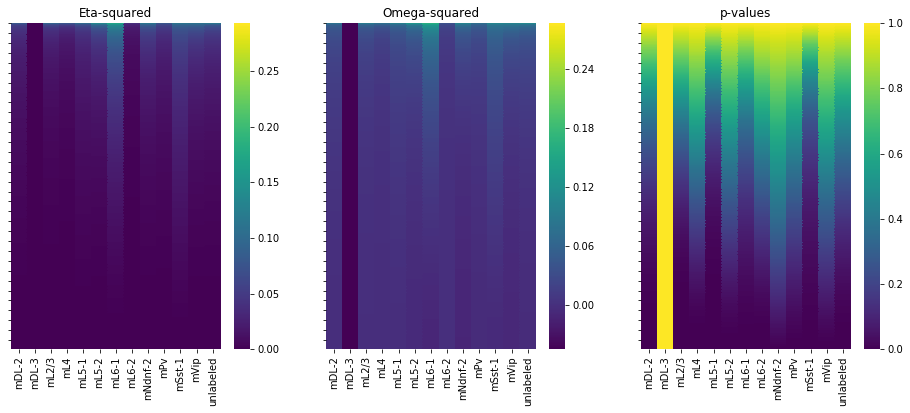

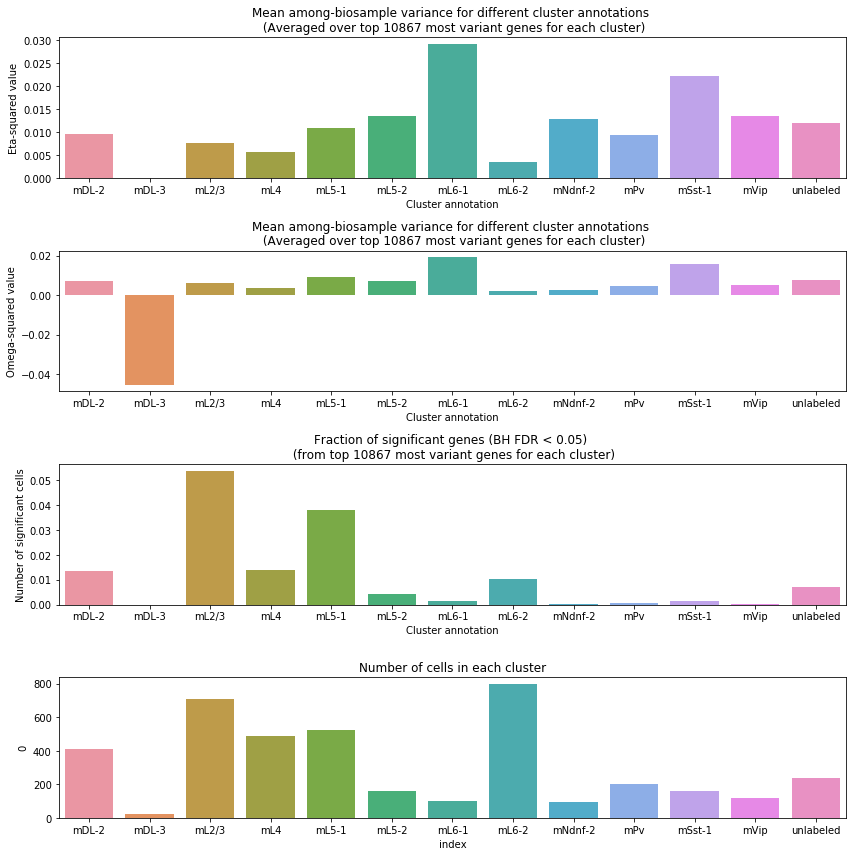

In [24]:
# eta-squared, omega-squared, and p-values 

df_res1 = df_eta
df_res2 = df_ome
df_res3 = df_p
n_top = df_res1.shape[0] 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_p.columns:
    rejs, *dis = multipletests(df_p[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()



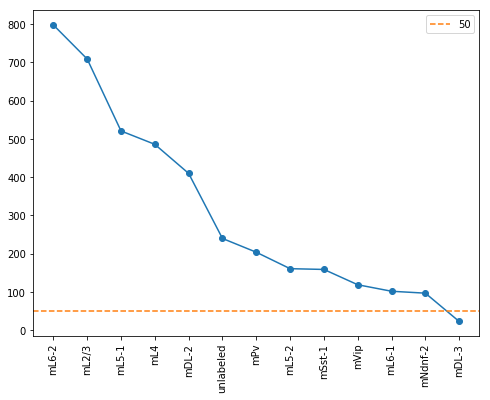

mDL-2        410
mL2/3        709
mL4          486
mL5-1        521
mL5-2        161
mL6-1        102
mL6-2        798
mNdnf-2       97
mPv          204
mSst-1       159
mVip         119
unlabeled    240
dtype: int64

In [25]:
# number of cells in each cluster

sr_n_sorted = sr_n.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 6))
# sns.barplot(x='index', y=0, data=sr_n.sort_values(ascending=False).to_frame().reset_index(), ax=ax)
# ax.set_title('Number of cells in each cluster')

ax.plot(sr_n_sorted.values, '-o')
ax.set_xticklabels(sr_n_sorted.index.values, rotation=90)
ax.set_xticks([i for i in range(sr_n.shape[0])])
ax.axhline(y=50, ls='dashed', color='C1', label='50')
ax.legend()
plt.show()

sr_n_tr = sr_n.loc[sr_n.index.isin(sr_n_sorted[(sr_n_sorted > 50)].index)]
sr_n_tr

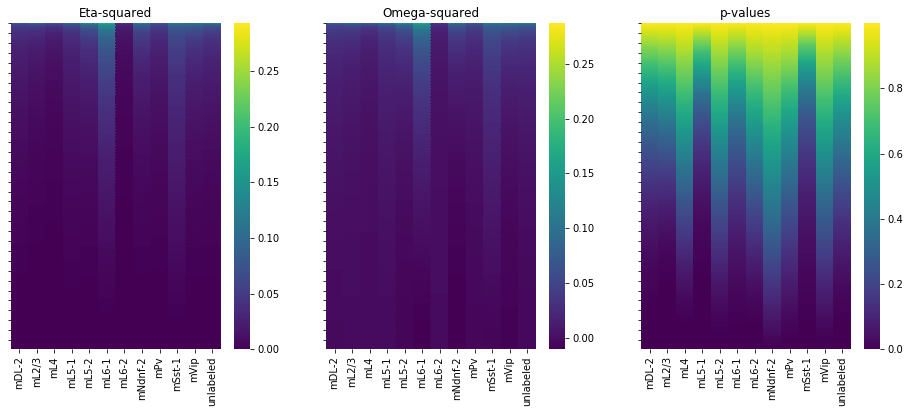

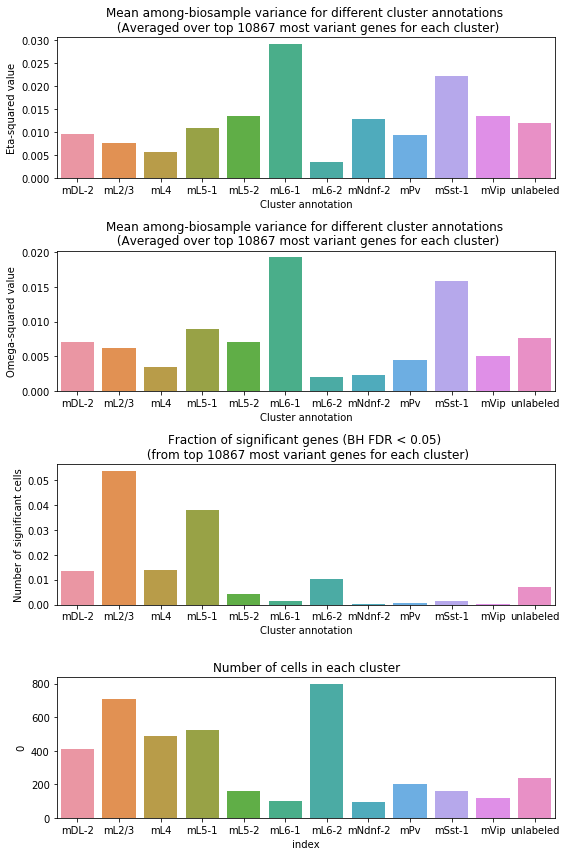

In [26]:
# rerun with truncated set of celltypes

# eta-squared, omega-squared, and p-values 

cell_types_tr = sr_n_tr.index.values  

df_res1 = df_eta[cell_types_tr]
df_res2 = df_ome[cell_types_tr]
df_res3 = df_p[cell_types_tr]
n_top = df_res1.shape[0] 
# n_top = 50 

df_res_ordered1 = order_df_res(df_res1)
df_res_ordered2 = order_df_res(df_res2)
df_res_ordered3 = order_df_res(df_res3)
    
df_plot1 = df_res_ordered1.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot1.reset_index(level=0, inplace=True)
df_plot1.columns = ['Cluster annotation', 'Eta-squared value']

df_plot2 = df_res_ordered2.iloc[:n_top, :].mean(axis=0).to_frame()
df_plot2.reset_index(level=0, inplace=True)
df_plot2.columns = ['Cluster annotation', 'Omega-squared value']

# number of variant genes
df_plot3 = pd.Series()
for col in df_res3.columns:
    rejs, *dis = multipletests(df_res3[col], alpha=0.05, method='hs')
    df_plot3[col] = rejs.sum()
df_plot3 = (df_plot3/df_p.shape[0]).to_frame().reset_index()
df_plot3.columns = ['Cluster annotation', 'Number of significant cells']


fig, axs = plt.subplots(1, 3, figsize=(16, 6))
ax = axs[0]
sns.heatmap(df_res_ordered1.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Eta-squared')
ax.set_yticklabels([])
ax = axs[1]
sns.heatmap(df_res_ordered2.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('Omega-squared')
ax.set_yticklabels([])
ax = axs[2]
sns.heatmap(df_res_ordered3.iloc[:n_top, :], cmap='viridis', ax=ax)
ax.set_title('p-values')
ax.set_yticklabels([])
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(8, 12))
ax = axs[0]
sns.barplot(x='Cluster annotation', y='Eta-squared value', data=df_plot1, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[1]
sns.barplot(x='Cluster annotation', y='Omega-squared value', data=df_plot2, ax=ax)
ax.set_title('Mean among-biosample variance for different cluster annotations \n (Averaged over top %d most variant genes for each cluster)' % n_top)
ax = axs[2]
sns.barplot(x='Cluster annotation', y='Number of significant cells', data=df_plot3, ax=ax)
ax.set_title('Fraction of significant genes (BH FDR < 0.05) \n (from top %d most variant genes for each cluster)' % n_top)
ax = axs[3]
sns.barplot(x='index', y=0, data=sr_n_tr.to_frame().reset_index(), ax=ax)
ax.set_title('Number of cells in each cluster')
fig.tight_layout()
plt.show()


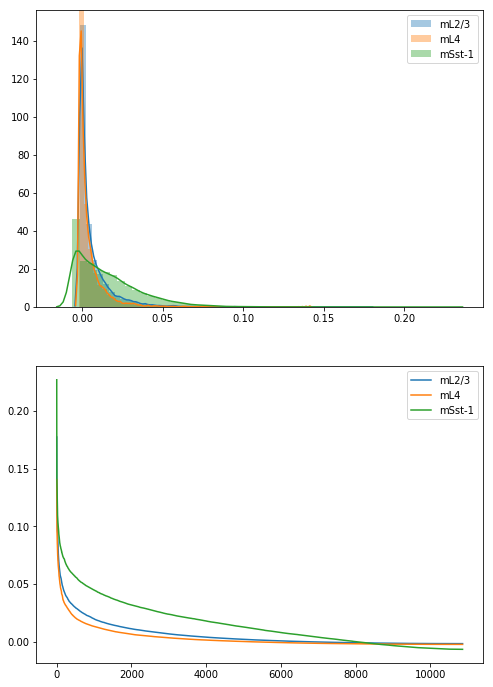

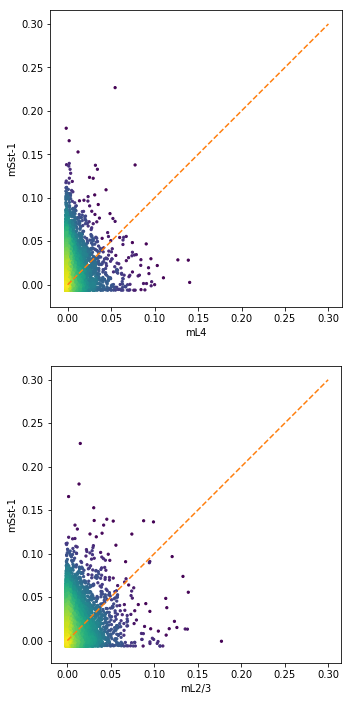

In [27]:
# eta-squared 
df_res = df_ome
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
sns.distplot(df_res['mL2/3'].values, ax=ax, label='mL2/3')
sns.distplot(df_res['mL4'].values, ax=ax, label='mL4')
# sns.distplot(df_res['hL5-2'].values, ax=ax, label='hL5-2')
# sns.distplot(df_res['mPv'].values, ax=ax, label='mPv')
sns.distplot(df_res['mSst-1'].values, ax=ax, label='mSst-1')
# sns.distplot(df_res['hNdnf'].values, ax=ax, label='hNdnf')
ax.legend()

ax = axs[1]
ax.plot(df_res_ordered['mL2/3'].values, label='mL2/3')
ax.plot(df_res_ordered['mL4'].values, label='mL4')
# ax.plot(df_res_ordered['hL5-2'].values, label='hL5-2')
# ax.plot(df_res_ordered['mPv'].values, label='mPv')
ax.plot(df_res_ordered['mSst-1'].values, label='mSst-1')
# ax.plot(df_res_ordered['hNdnf'].values, label='hNdnf')
# ax.set_yscale('log')
ax.legend()
plt.show()


fig, axs = plt.subplots(2, 1, figsize=(8, 12))
ax = axs[0]
xy = np.vstack([df_res['mL4'].values, df_res['mSst-1'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['mL4'].values, df_res['mSst-1'].values, c=np.log10(z), s=5)
ax.set_xlabel('mL4')
ax.set_ylabel('mSst-1')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')

ax = axs[1]
xy = np.vstack([df_res['mL2/3'].values, df_res['mSst-1'].values]) 
z = gaussian_kde(xy)(xy)
ax.scatter(df_res['mL2/3'].values, df_res['mSst-1'].values, c=np.log10(z), s=5)
ax.set_xlabel('mL2/3')
ax.set_ylabel('mSst-1')
line_x = np.arange(0, 0.4, 0.1)
line_y = np.arange(0, 0.4, 0.1)
ax.plot(line_x, line_y, '--', color='C1')
ax.set_aspect('equal')
plt.show()



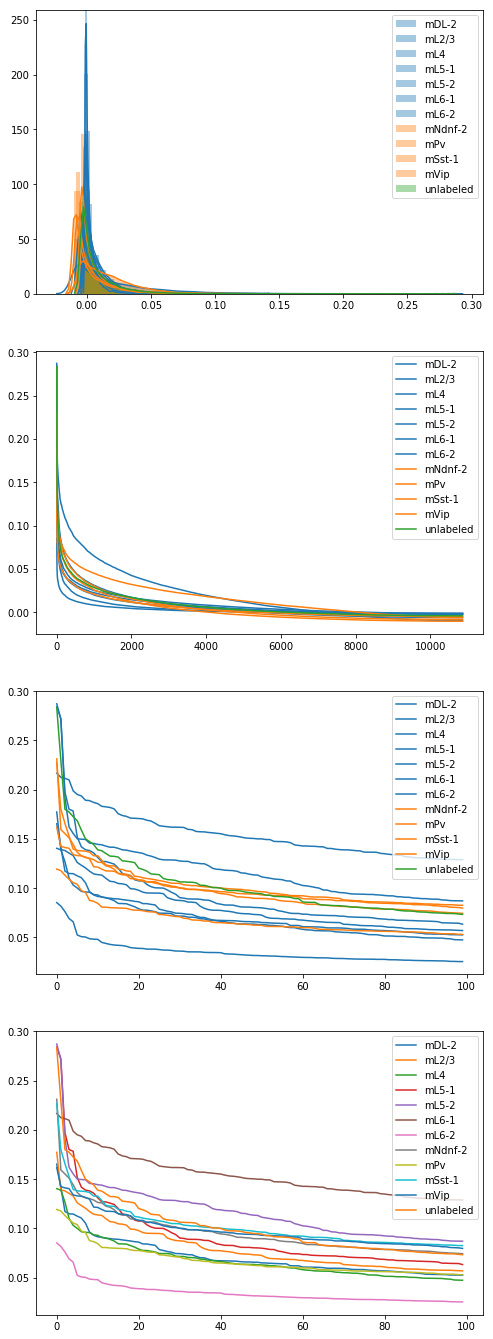

In [44]:
# eta-squared

# df_cell_class.loc[cell_types_tr].groupby('cell_class')

cell_types_tr = sr_n_tr.index.tolist()
df_res = df_ome[cell_types_tr] 
n_top = df_res.shape[0] 

df_res_ordered = pd.DataFrame()
for col in df_res.columns:
    df_res_ordered[col] = df_res[col].sort_values(ascending=False).values
    
fig, axs = plt.subplots(4, 1, figsize=(8, 6*4))
ax = axs[0]
for col in df_res.columns:
    values = df_res[col].values
    values = values[~np.isnan(values)]
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        sns.distplot(values, ax=ax, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        sns.distplot(values, ax=ax, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        sns.distplot(values, ax=ax, label=col, color='C2')
ax.legend()

ax = axs[1]
for col in df_res.columns:
    values = df_res_ordered[col].values
    values = values[~np.isnan(values)]
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(values, label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(values, label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(values, label=col, color='C2')
ax.legend()

ax = axs[2]
n_tops = 100
for col in df_res.columns:
    values = df_res_ordered[col].values
    values = values[~np.isnan(values)]
    if df_cell_class.loc[col, 'cell_class'] == 'Ex':
        ax.plot(values[:n_tops], label=col, color='C0')
    elif df_cell_class.loc[col, 'cell_class'] == 'In':
        ax.plot(values[:n_tops], label=col, color='C1')
    elif df_cell_class.loc[col, 'cell_class'] == 'Glia':
        ax.plot(values[:n_tops], label=col, color='C2')
ax.legend()

ax = axs[3]
n_tops = 100
for col in df_res.columns:
    values = df_res_ordered[col].values
    values = values[~np.isnan(values)]
    ax.plot(values[:n_tops], label=col)
ax.legend()
plt.show()



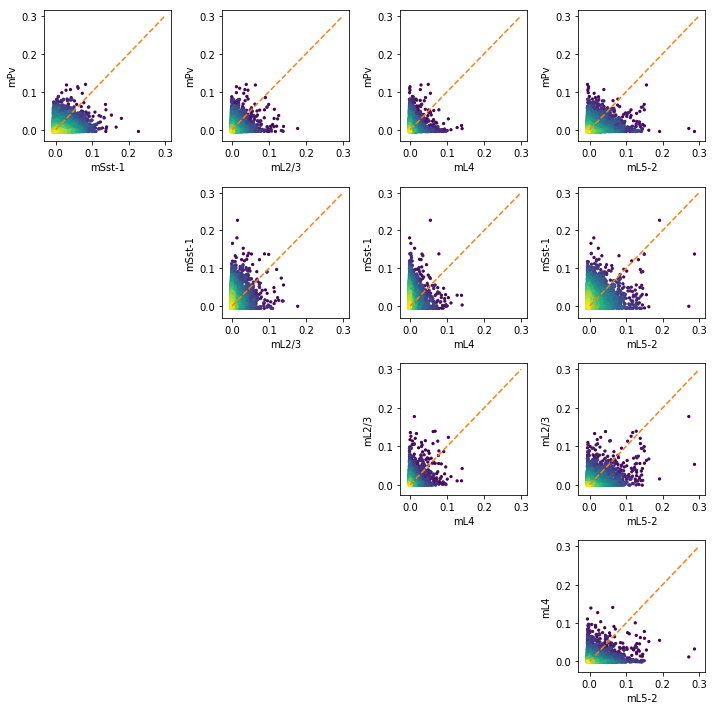

In [29]:
# hPv-1, hSst-2, hL2/3, hL4, hL5-2

cell_types_tr2 = ['mPv', 'mSst-1', 'mL2/3', 'mL4', 'mL5-2']
n = len(cell_types_tr2)

fig, axs = plt.subplots(n, n, figsize=(12, 12))
for i, j in zip(*np.tril_indices_from(axs, k=0)):
    axs[i, j].set_visible(False)
for i, j in zip(*np.triu_indices_from(axs, k=1)):
    ax = axs[i, j]
    cti = cell_types_tr2[j]
    ctj = cell_types_tr2[i]
    xy = np.vstack([df_res[cti].values, df_res[ctj].values]) 
    z = gaussian_kde(xy)(xy)
    ax.scatter(df_res[cti].values, df_res[ctj].values, c=np.log10(z), s=5)
    ax.set_xlabel(cti)
    ax.set_ylabel(ctj)
    line_x = np.arange(0, 0.4, 0.1)
    line_y = np.arange(0, 0.4, 0.1)
    ax.plot(line_x, line_y, '--', color='C1')
    ax.set_aspect('auto')
    
fig.tight_layout()
plt.show()



# Look at one cell type (hL4)

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics 
from sklearn.model_selection import KFold

# number of cells from each biosample

def get_data(celltype):
    cells = df_info[df_info.cluster_annotation==celltype].index.values
#     cells_v1 = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_v1')].index.values
#     cells_EA = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EA')].index.values
#     cells_EB = df_info[(df_info.cluster_annotation==celltype) & (df_info.Biosample=='MB_EB')].index.values
#     print(np.asarray([cells_v1.shape[0], cells_EA.shape[0], cells_EB.shape[0]])/cells.shape[0])

    # generate data
    cells = df_info[df_info['cluster_annotation']==celltype].index.values
    y = df_info.loc[cells, 'Biosample']
    X0 = df_mcc.loc[df_p.sample(frac=1).index.values, cells+'_mcc'].T 
    X0.index = [cell[:-len('_mcc')] for cell in X0.index]
    X1 = df_mcc.loc[df_p[celltype].sort_values().index.values, cells+'_mcc'].T 
    X1.index = [cell[:-len('_mcc')] for cell in X1.index]
    df_xy0 = pd.merge(X0, y.to_frame(), left_index=True, right_index=True)
    df_xy1 = pd.merge(X1, y.to_frame(), left_index=True, right_index=True)
#     print(df_xy0.shape)
#     print(df_xy1.shape)
    return df_xy0, df_xy1
    

In [31]:
def LDA_xvalid(df_xy, n_splits=5, n_tops=np.arange(1, 100, 2), classifier='LDA'):
    """
    X = regex="^ENS"
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    # n_tops = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    split_scheme = list(kf.split(df_xy))
    for n_top in n_tops:
        accs = []
        f1_micros = []
        f1_macros = []
        for i, (train_index, test_index) in enumerate(split_scheme):
            X_train = df_xy.iloc[train_index, :n_top].filter(regex='^ENS')
            X_test = df_xy.iloc[test_index, :n_top].filter(regex='^ENS')
            y_train = df_xy.iloc[train_index, :].Biosample
            y_test = df_xy.iloc[test_index, :].Biosample

            # train LDA model
            if classifier == 'LDA':
                lda = LDA().fit(X_train, y_train)
                y_pred = lda.predict(X_test)
            elif classifier == 'RFC':
                rfc = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
                y_pred = rfc.predict(X_test)

            # evaluate
            acc = metrics.accuracy_score(y_test, y_pred)
            f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
            f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
            accs.append(acc)
            f1_micros.append(f1_micro)
            f1_macros.append(f1_macro)

    #         if i == 0:
    #             conf_mat = metrics.confusion_matrix(y_test, y_pred)
    #             print(conf_mat)


        mean_acc = np.mean(accs)
        mean_f1_micro = np.mean(f1_micros)
        mean_f1_macro = np.mean(f1_macros)

        mean_accs.append(mean_acc)
        mean_f1_micros.append(mean_f1_micro)
        mean_f1_macros.append(mean_f1_macro)

    return mean_accs, mean_f2_micros, mean_f1_macros


In [32]:
def LDA_pca_xvalid(X, y, n_splits=5, classifier='LDA', metric_auroc=False):
    """
    X = regex="^\("
    y = "Biosample"
    
    """
    # 5-fold cv with LDA
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    mean_accs = []
    mean_f1_micros = []
    mean_f1_macros = []
    if metric_auroc:
        mean_aurocs = []
    split_scheme = list(kf.split(y))
 
    accs = []
    f1_micros = []
    f1_macros = []
    if metric_auroc:
        aurocs = []
    for i, (train_index, test_index) in enumerate(split_scheme):
        X_train = X[train_index] 
        X_test = X[test_index] 
        y_train = y[train_index] 
        y_test = y[test_index] 

        # train LDA model
        if classifier == 'LDA':
            res_fit = LDA().fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)
            y_pred_p = res_fit.predict_proba(X_test)[:,1]
        elif classifier == 'RFC':
            res_fit = RFC(n_estimators=10, random_state=1).fit(X_train, y_train)
            y_pred = res_fit.predict(X_test)
            y_pred_p = res_fit.predict_proba(X_test)[:,1]

        # evaluate
        acc = metrics.accuracy_score(y_test, y_pred)
        f1_micro = metrics.f1_score(y_test, y_pred, average='micro')
        f1_macro = metrics.f1_score(y_test, y_pred, average='macro')
        
        accs.append(acc)
        f1_micros.append(f1_micro)
        f1_macros.append(f1_macro)

        if metric_auroc:
            y_factors, y_labels = pd.factorize(y_test) 
            fpr, tpr, thresholds = metrics.roc_curve(y_factors, y_pred_p)
            auroc = metrics.auc(fpr, tpr)
            aurocs.append(auroc)
#         if i == 0:
#             conf_mat = metrics.confusion_matrix(y_test, y_pred)
#             print(conf_mat)


    mean_acc = np.mean(accs)
    mean_f1_micro = np.mean(f1_micros)
    mean_f1_macro = np.mean(f1_macros)
    if metric_auroc:
        mean_auroc = np.mean(aurocs)
    if metric_auroc:
        return mean_acc, mean_f1_micro, mean_f1_macro, mean_auroc
    else:
        return mean_acc, mean_f1_micro, mean_f1_macro


In [33]:
# PCA regression
# top n PCs
n_tops = [5, 10, 20, 30, 40, 50]

cell_types_tr2 = sr_n_tr.index.values

res_dct = OrderedDict()
for celltype in cell_types_tr2:
    df_xy0, df_xy1 = get_data(celltype)
    X = df_xy1.filter(regex='^ENS').values
    y = df_xy1.Biosample.values
    
    accs = []
    f1_mis = []
    f1_mas = []
    aurocs = []
    for n_top in n_tops:
        
        pca = PCA(n_components=n_top)
        pcX = pca.fit_transform(X)

        acc, f1_mi, f1_ma, auroc = LDA_pca_xvalid(pcX, y, classifier='LDA', metric_auroc=True)
        accs.append(acc)
        f1_mis.append(f1_mi)
        f1_mas.append(f1_ma)
        aurocs.append(auroc)
    
    res_dct[celltype] = (accs, f1_mis, f1_mas, aurocs) 

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [1]:
# plot PCA regression results
cell_types_tr2 = sr_n_tr.index.values
n_tops = [5, 10, 20, 30, 40, 50]

colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# micro
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=colors[i%len(colors)], label='{}_f1_micro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][3], ':o', color=colors[i%len(colors)], label='{}_auroc'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][1], '--o', color=c, label='{}_f1_micro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
#     ax.plot(n_tops, res_dct[celltype][3], ':o', color=c, label='{}_auroc'.format(celltype))
# ax.legend()
plt.show()


# macro
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=colors[i%len(colors)], label='{}_f1_macro'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][2], '-o', color=c, label='{}_f1_macro'.format(celltype))
# ax.legend()
plt.show()


# auroc 
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
ax = axs[0]
for i, celltype in enumerate(cell_types_tr2):
    ax.plot(n_tops, res_dct[celltype][3], '-o', color=colors[i%len(colors)], label='{}_auroc'.format(celltype))
ax.legend()

ax = axs[1]
for i, celltype in enumerate(cell_types_tr2):
    if celltype in df_cell_class[df_cell_class.cell_class=='Ex'].index.values:
        c = 'C0'
    elif celltype in df_cell_class[df_cell_class.cell_class=='In'].index.values:
        c = 'C1'
    elif celltype in df_cell_class[df_cell_class.cell_class=='Glia'].index.values:
        c = 'C2'
    else:
        c = 'C7'
    ax.plot(n_tops, res_dct[celltype][3], ':o', color=c, label='{}_auroc'.format(celltype))
# ax.legend()
plt.show()

NameError: name 'sr_n_tr' is not defined

/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/cndd/fangming/venvs/venv_banjo_snmcseq/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


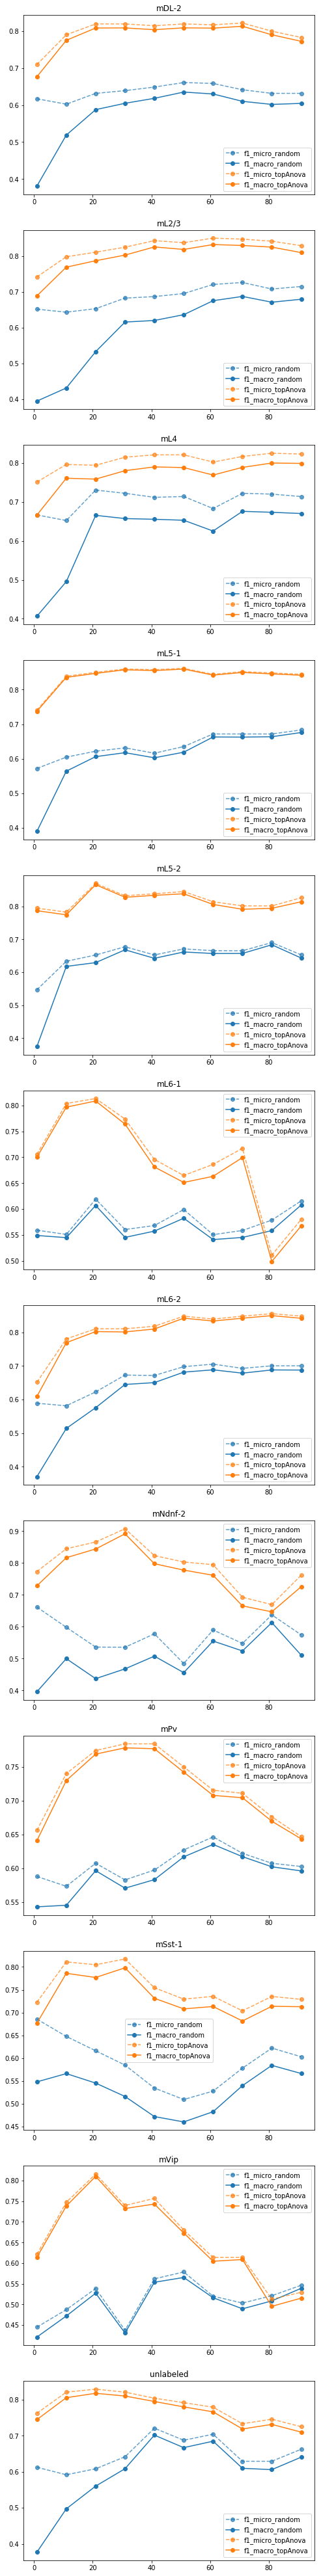

In [35]:
# LDA top genes
n = len(cell_types_tr2)
n_tops = np.arange(1, 100, 10)

fig, axs = plt.subplots(n, 1, figsize=(8, 6*n))
for celltype, ax in zip(cell_types_tr2, axs):
    
    df_xy0, df_xy1 = get_data(celltype)
    accs0, f1_micros0, f1_macros0 = LDA_xvalid(df_xy0, n_tops=n_tops, classifier='LDA')
    accs1, f1_micros1, f1_macros1 = LDA_xvalid(df_xy1, n_tops=n_tops, classifier='LDA')

    ax.plot(n_tops, f1_micros0, '--o', label='f1_micro_random', color='C0', alpha=0.7)
    ax.plot(n_tops, f1_macros0, '-o', label='f1_macro_random', color='C0')
    ax.plot(n_tops, f1_micros1, '--o', label='f1_micro_topAnova', color='C1', alpha=0.7)
    ax.plot(n_tops, f1_macros1, '-o', label='f1_macro_topAnova', color='C1')
    ax.set_title(celltype)
    ax.legend()
plt.show()

In [36]:
# What are the top 30 genes?
n_top = 20
top_genes = pd.DataFrame()
for celltype in cell_types_tr2:
    sr_top_genes = df_gene.loc[df_p[celltype].sort_values().index.values[:n_top], 'geneName']
    top_genes[celltype] = sr_top_genes.values
top_genes

mDL-2          mL2/3      mL4    mL5-1    mL5-2    mL6-1  \
0          Skint5          Tenm2   Kcnip4   Zbtb16  Gm26573    Dip2b   
1          Gm2619  C230088H06Rik    Rcan2    Tenm2    Tenm2  Gm39094   
2           Asap1          Cdh11     Lmf1     Nfix   Skint5     Dnm3   
3           Pcdh9           Nav3    Itpr1    Cdh11     Nfix  Gm20458   
4          Bcl11a          Csmd3     Dlg2    Chrm3   Grin2b  Dennd1a   
5   C230088H06Rik          Dclk1   Zbtb16    Celf2   Snhg14   Unc13c   
6           Tanc2           Dlg2     Cdh2   Rnf150   Skint6    Dock4   
7            Vwc2          Tanc2    Chrm3  Gm37013  Gm42416     Sys1   
8         Runx1t1          Celf2   Gabra5  Gm42416  Gm37013  Khdrbs3   
9           Tenm2           Sfi1    Pcdh7  Gm37388  Skint10  Gm12296   
10         Zfp935          Lrrc7   Hivep1    Lrrc7    Scn2a    Erp29   
11        Gm12374        Gm26624    Opcml   Pcdh15    Efna5   Diaph3   
12          Pcsk2          Gria4    Galk2  Phactr1    Ube3c   Dcbld2   
13        Gm42416            Ntm   Tmeff1    Pde1a  Gm37388     Cog5   
14        Gm26624          Cadm2    Negr1    Pcdh9    Prkcb   Lrrc4c   
15          Cdh11         Nkain2    Apbb2   Nkain2    Plcb4   Kcnab2   
16           Zeb2          Csmd1     Dkk3   Skint6      Ntm  Gm11639   
17           Cmip        Runx1t1    Kcnb2      Ntm    Tanc2   Mgat4c   
18        Gm37013           Etv6  Gm28928    Dleu2    Myt1l     Nfix   
19         Zbtb16        Gm42416    Zfpm2     Syt1    Il6st    Rgs20   

            mL6-2        mNdnf-2       mPv   mSst-1           mVip  \
0          Skint5  C230088H06Rik    Gm2619   Skint5          Syne1   
1           Tanc2  4933406K04Rik    Grin2b     Itch           Tcf4   
2         Gm26573          Nudt3     Gsk3b    Ints1        Gm42416   
3   C230088H06Rik         Galnt9     Kif5c   Snap47        Poldip3   
4           Strbp           Sfi1  Mapk8ip3   Cep350        Rps6ka2   
5          Mapk10        Gm26624      Xkr4  Slc6a17        Galnt18   
6         Gm26624         Skint6     Erbb4   Skint6        Gm37013   
7           Grik4           Raf1   Ankrd17  Gm26573         Zbtb7c   
8        Pafah1b1          Ap2a1    Hnrnpm  Gm42416        Gm37388   
9           Kif1a         Rspry1      Tcf4    Pi4ka         Ctnnd2   
10            Kit         Skint5    Zfp936   Camk2b        Cttnbp2   
11           Ubr4       Pafah1b1    Ndufs4      Ttl          Bicra   
12          Cdh11         Mboat2   Gm20716    Dock3          Frem1   
13         Nlrp9c         Nup160  Trappc10  Cacna1a        Gm34719   
14        Sult2a4          Fhdc1     Zzef1    Strbp           Fgf1   
15        Dync1h1        Gm26733     Acot7   Ergic1         Snhg14   
16        Gm26763         Ikbkap     Srrm4   Mical3         Ppp4r4   
17          Sulf2           Cluh   Sult2a4   Zfp738         Dnmt3a   
18        Fam135b          Zfp26    Atp1a3  Dennd5a  A530058N18Rik   
19          Ovol2           Noct   Gatad2b     Eea1        Slc44a5   

        unlabeled  
0         Gm26573  
1            Sfi1  
2   C230088H06Rik  
3            Sgcz  
4            Iqcm  
5          Gm2619  
6   C130026I21Rik  
7         Gm26624  
8            Drg1  
9          Snhg14  
10            Rp1  
11          Ptprd  
12         Grin2a  
13        Slc12a2  
14         Tmeff2  
15          Cdh12  
16        Cntnap2  
17         Malrd1  
18       Cdc42bpa  
19  A830018L16Rik

In [37]:
# What are the genes 
genes, counts = np.unique(top_genes.values.flatten(), return_counts=True)
top_genes_stats = pd.DataFrame()
top_genes_stats['gene_name'] = genes
top_genes_stats['number_of_occurance'] = counts

# filter out genes with low ranges
res = []
for gene_name in top_genes_stats.gene_name:
    gene_id = df_gene[df_gene.gene_name==gene_name].index.values[0]
    gene_table = id2table(gene_id)
    sql = """SELECT cell_name, mCH, CH, dataset, {}, {}
            FROM {} 
            JOIN cells 
            ON {}.cell_id = cells.cell_id
            JOIN {}
            ON {}.cell_id = cells.cell_id""".format(cluster_col, annot_col, gene_table, gene_table, ens, ens)
    dfg = pd.read_sql(sql, engine)
    dfg['mCH/CH'] = dfg.mCH/dfg.CH
    dfg['region'] = [dataset[len('CEMBA_'):-len('_171206')] for dataset in dfg['dataset']]
    dfg[annot_col] = dfg[annot_col].fillna('unlabeled')
    
    mcc_range = np.nanpercentile(dfg['mCH/CH'].values, 99) - np.nanpercentile(dfg['mCH/CH'].values, 1)
    res.append({'gene_name': gene_name, 'mCH_range': mcc_range})
res = pd.DataFrame(res)

top_genes_stats = pd.merge(top_genes_stats, res, on='gene_name')
top_genes_stats = top_genes_stats.sort_values('number_of_occurance', ascending=False)
top_genes_stats.head()

gene_name  number_of_occurance  mCH_range
76         Gm42416                    6   0.009377
12   C230088H06Rik                    5   0.009580
144         Skint5                    5   0.016424
68         Gm26624                    5   0.010339
73         Gm37013                    4   0.009379

In [38]:
# plt.plot(top_genes_stats['mCH_range'].values)
# plt.plot()
# top_genes_stats['mCH_range'].values.shape
top_genes_stats[top_genes_stats['mCH_range']>0.04].shape

(84, 3)

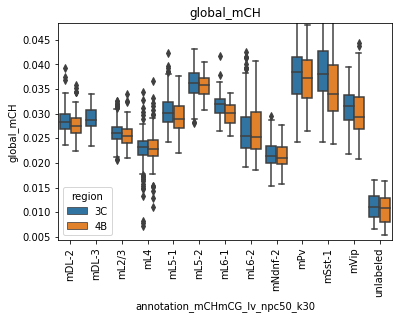

In [39]:
# global level

sql = """SELECT cell_name, global_mCH, dataset, {}, {}
        FROM cells 
        JOIN {}
        ON {}.cell_id = cells.cell_id""".format(cluster_col, annot_col, ens, ens)
dfg = pd.read_sql(sql, engine)
dfg['region'] = [dataset[len('CEMBA_'):-len('_171206')] for dataset in dfg['dataset']]
dfg[annot_col] = dfg[annot_col].fillna('unlabeled')
order = sorted(dfg[annot_col].unique().tolist())

fig, ax = plt.subplots()
sns.boxplot(x=annot_col, y='global_mCH', hue='region', order=order, data=dfg, ax=ax)
yrange = [np.nanpercentile(dfg['global_mCH'].values, 1), np.nanpercentile(dfg['global_mCH'].values, 99)]
yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
ax.set_ylim(yrange)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('global_mCH')
plt.show()

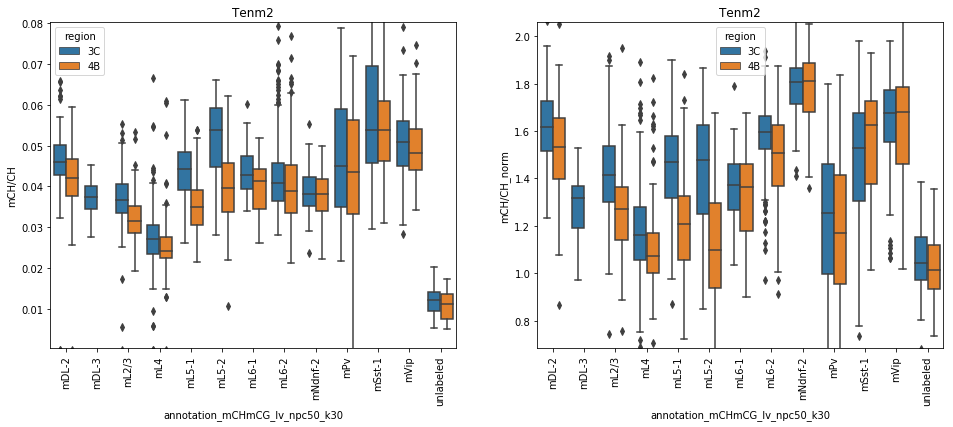

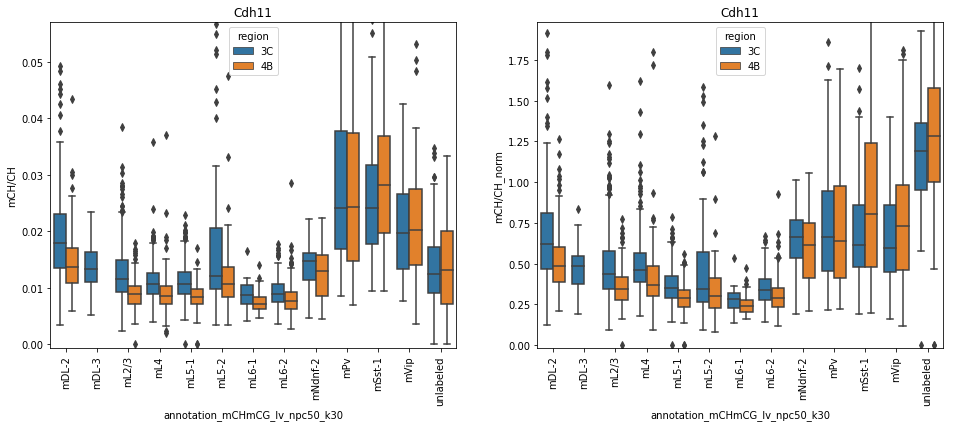

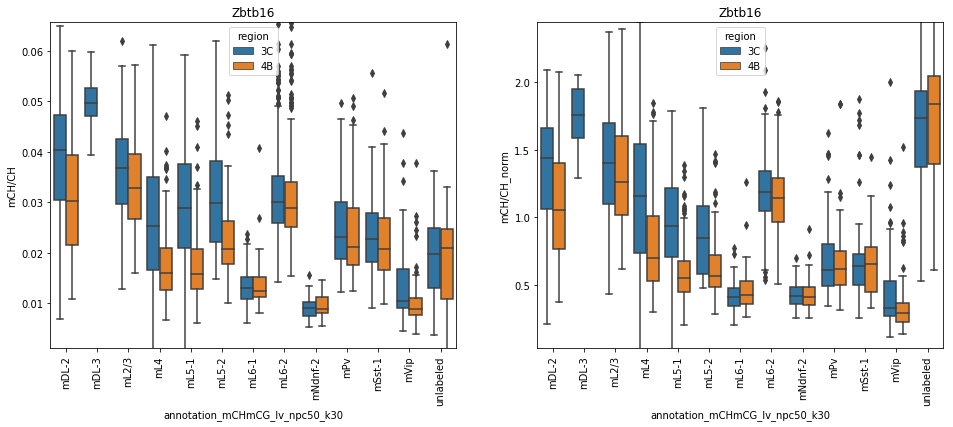

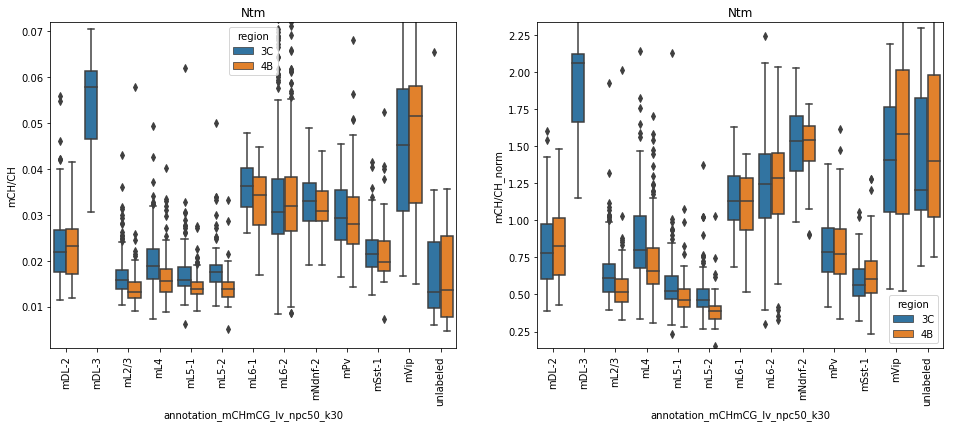

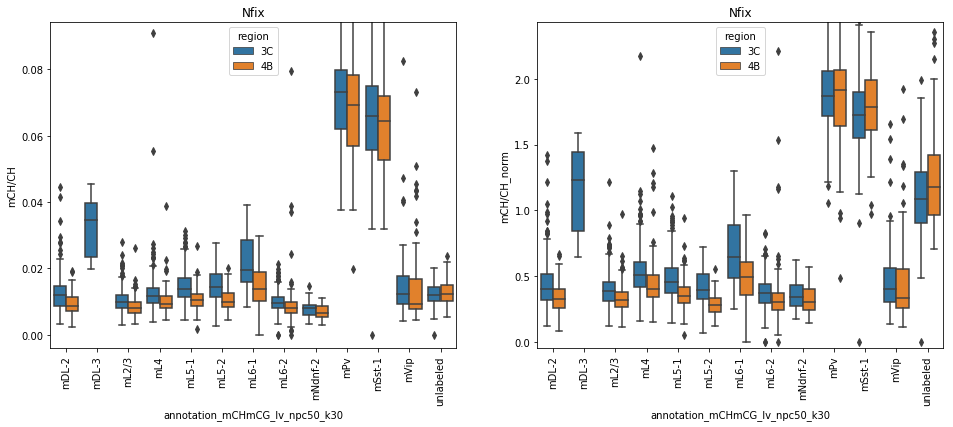

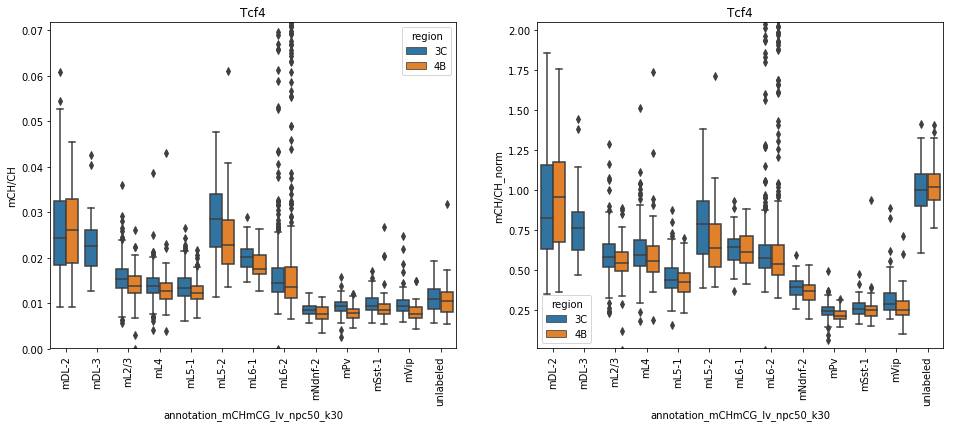

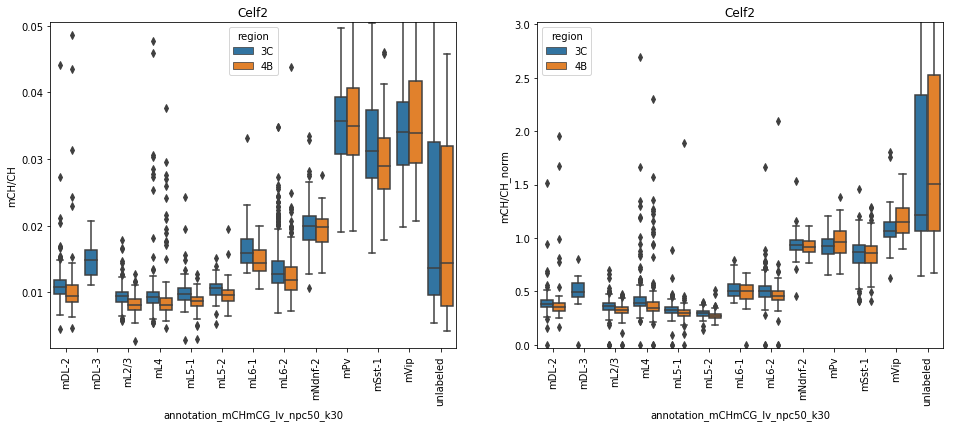

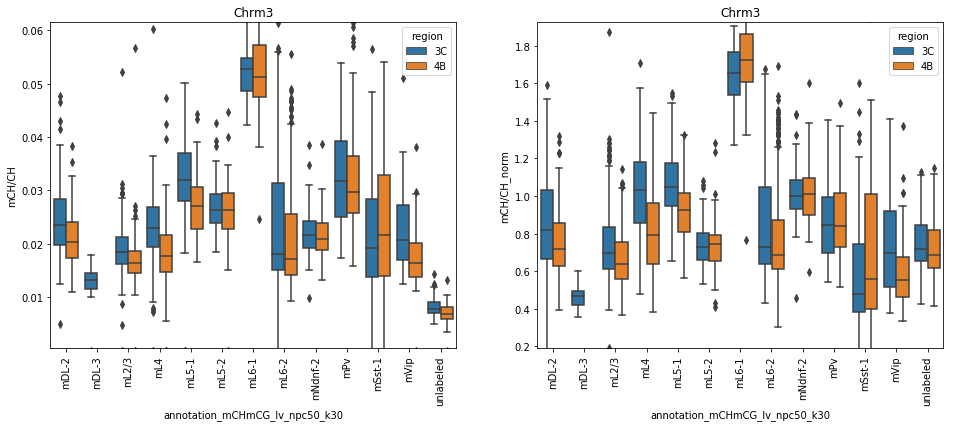

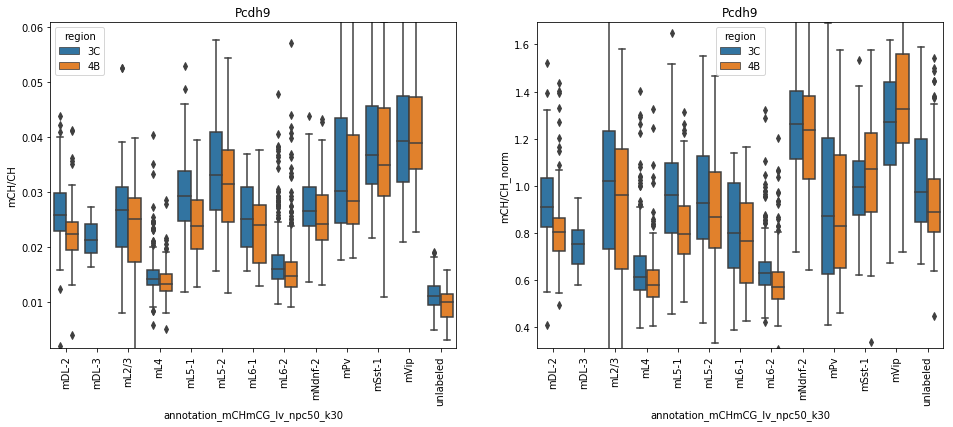

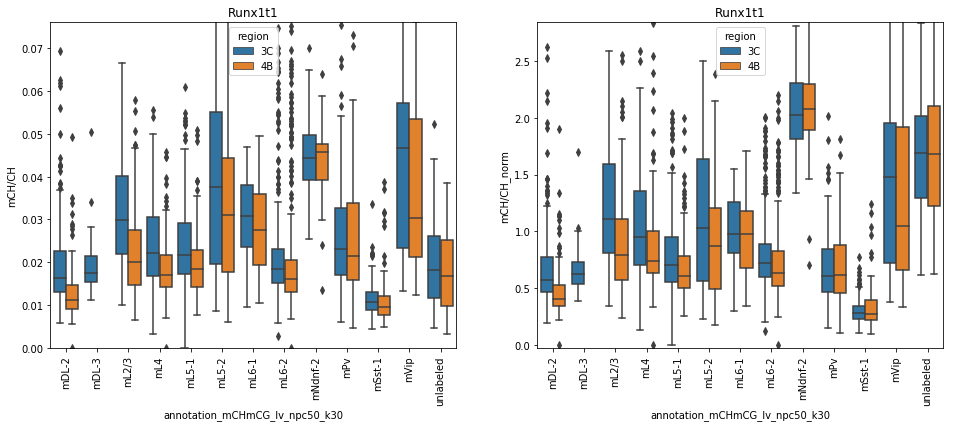

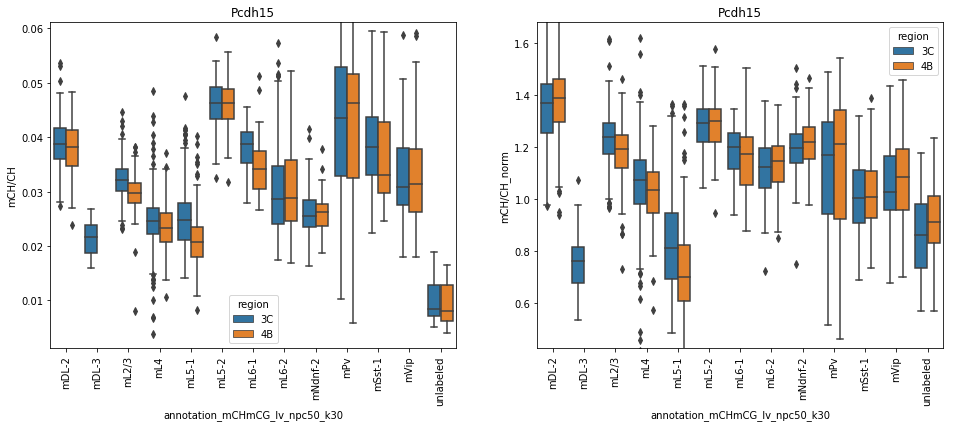

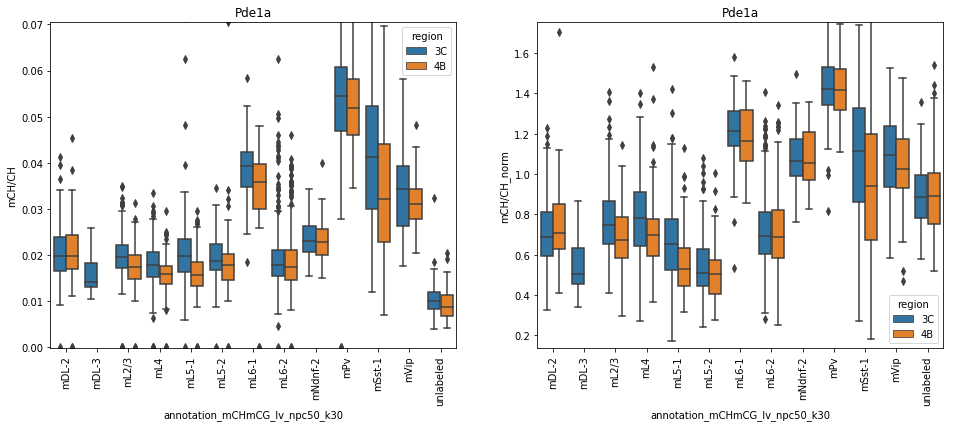

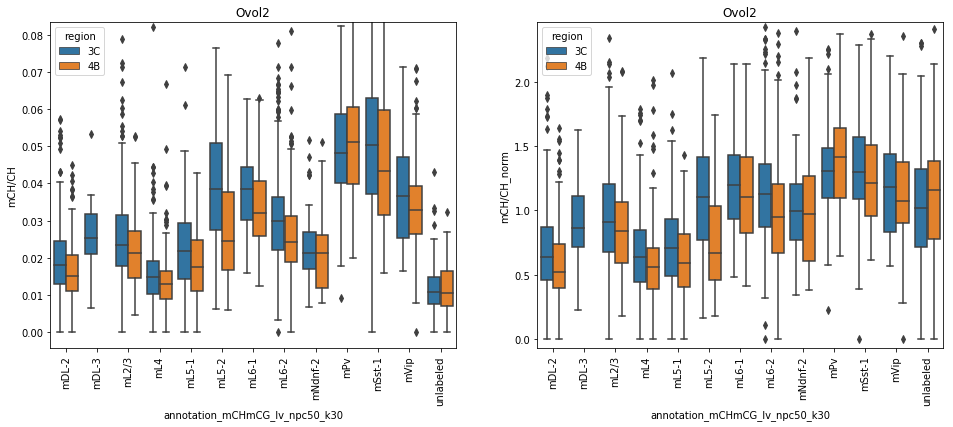

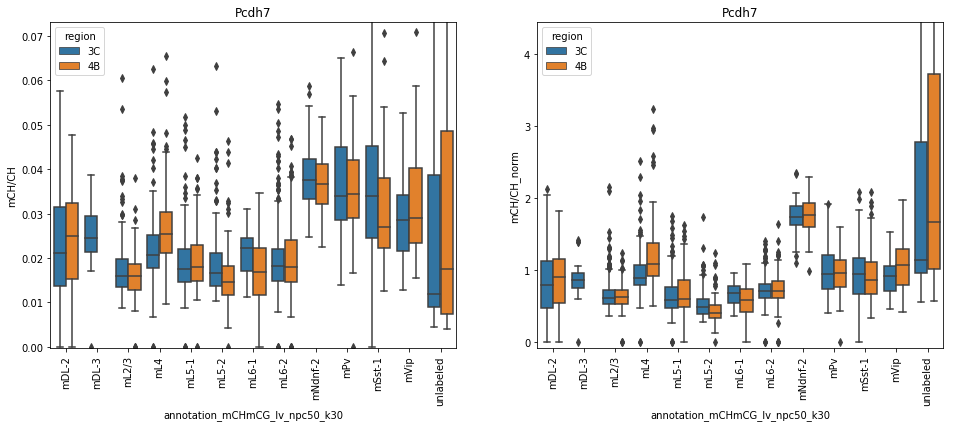

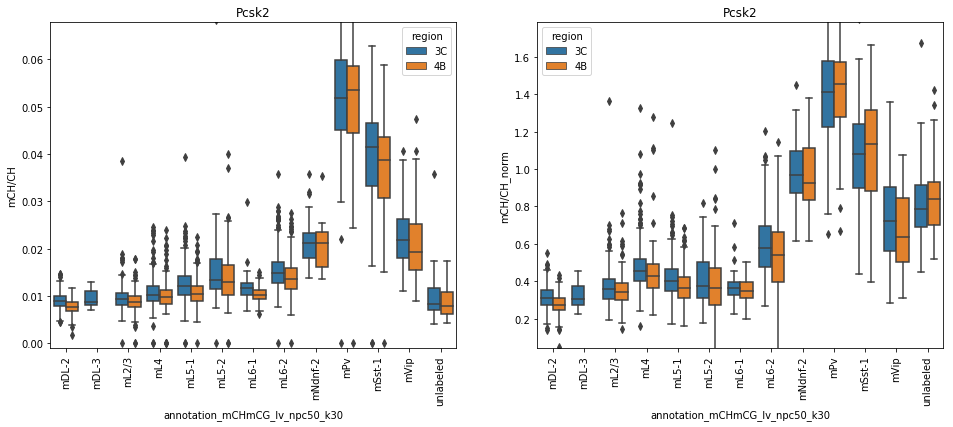

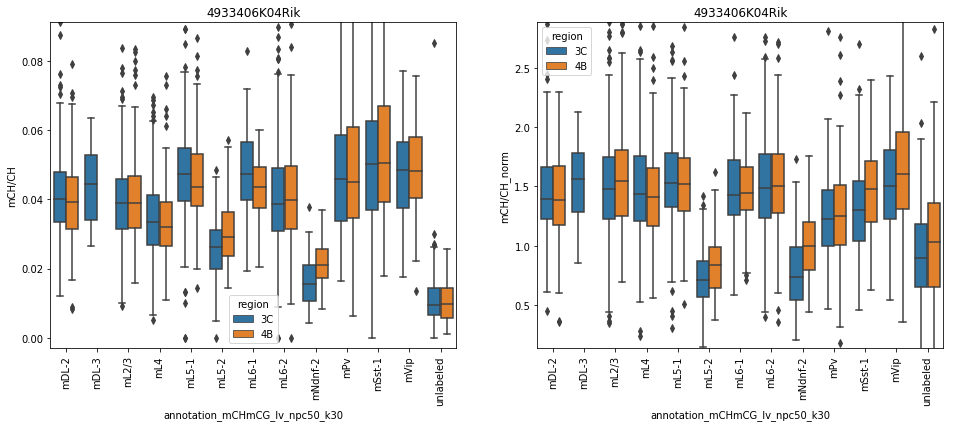

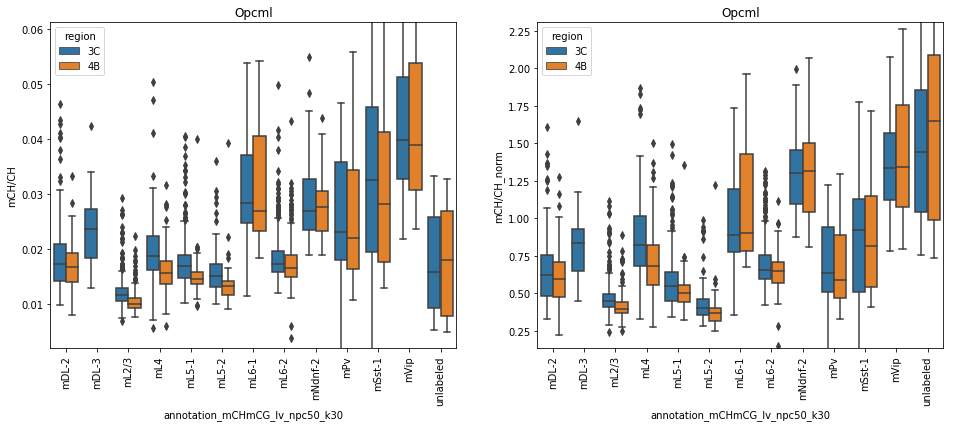

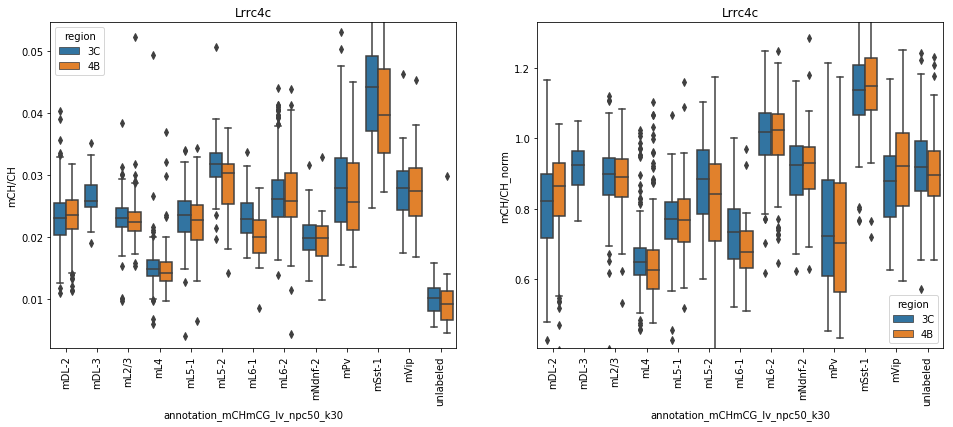

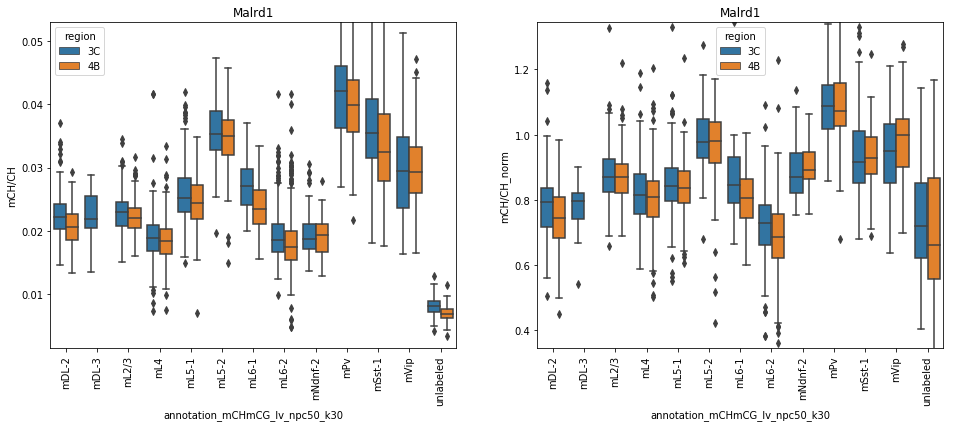

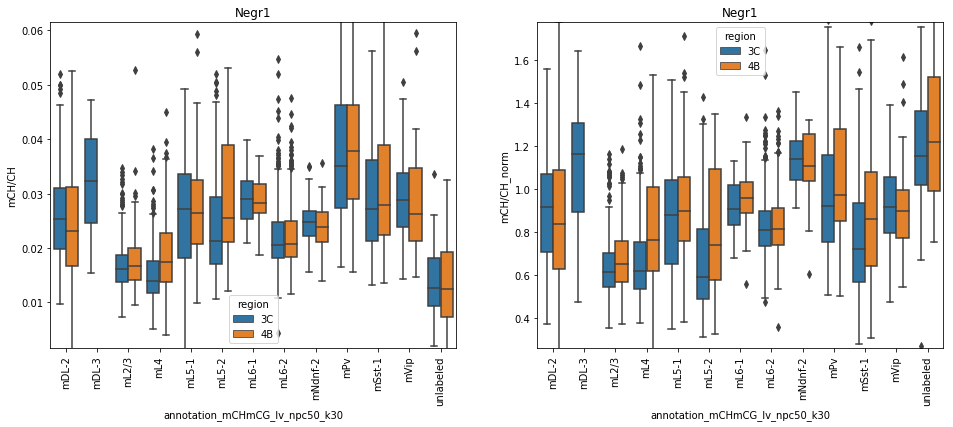

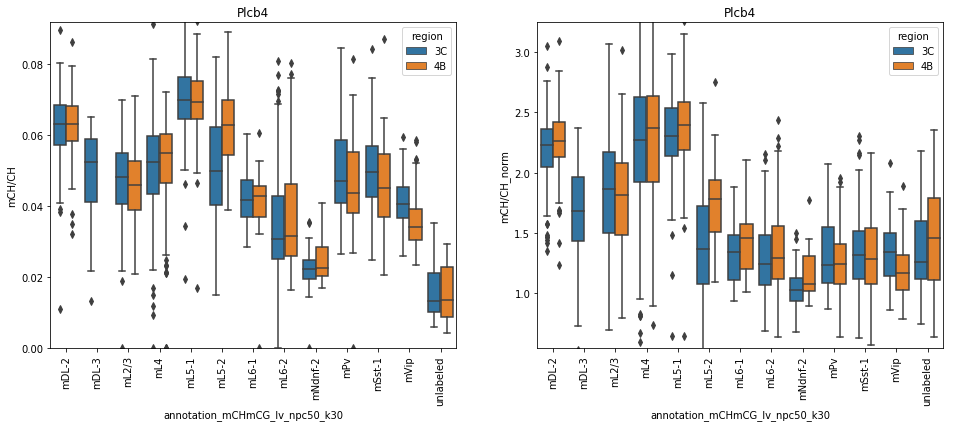

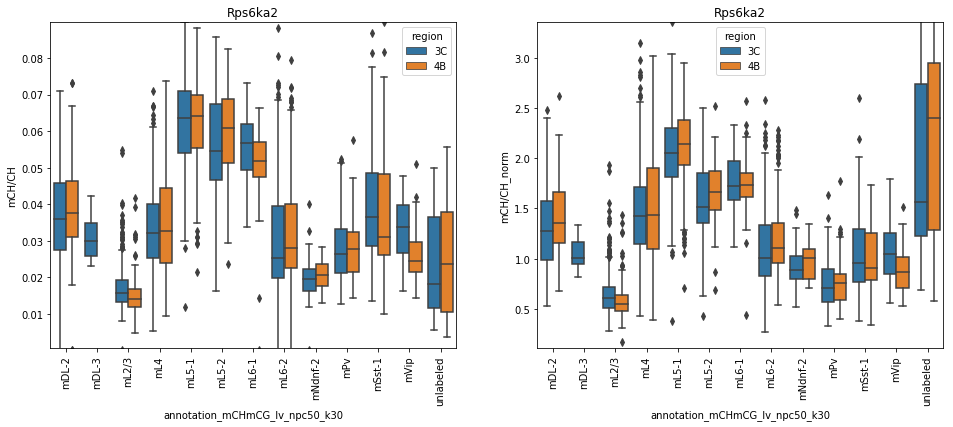

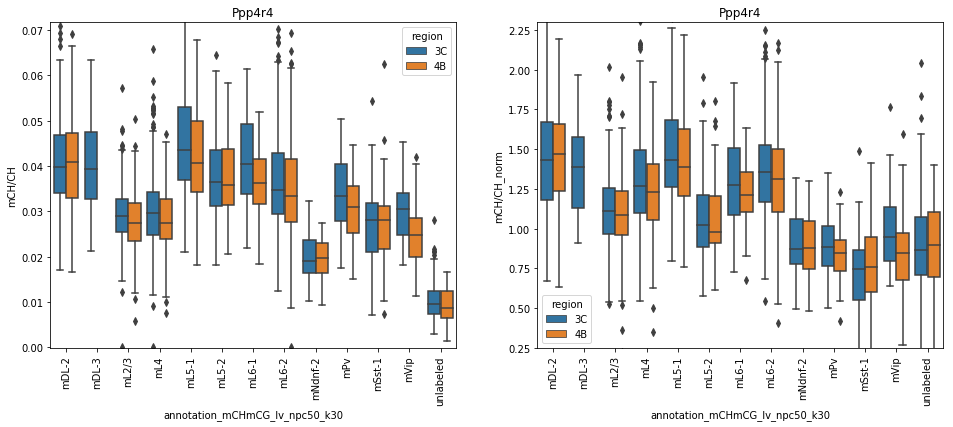

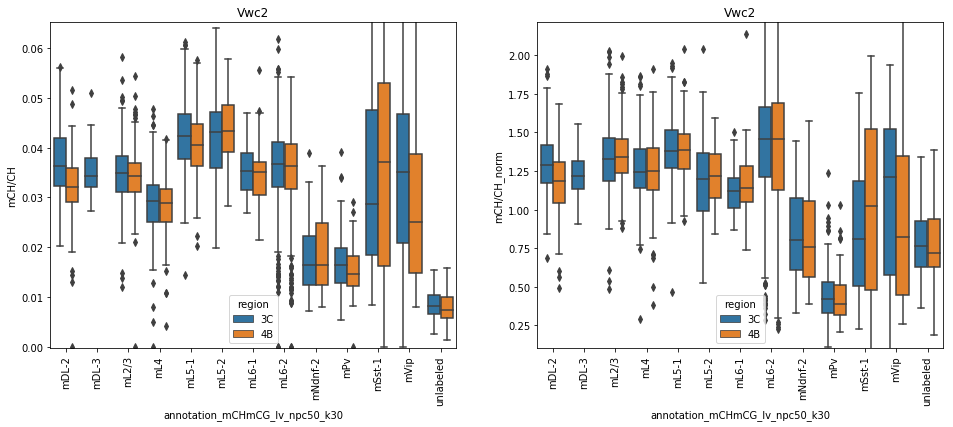

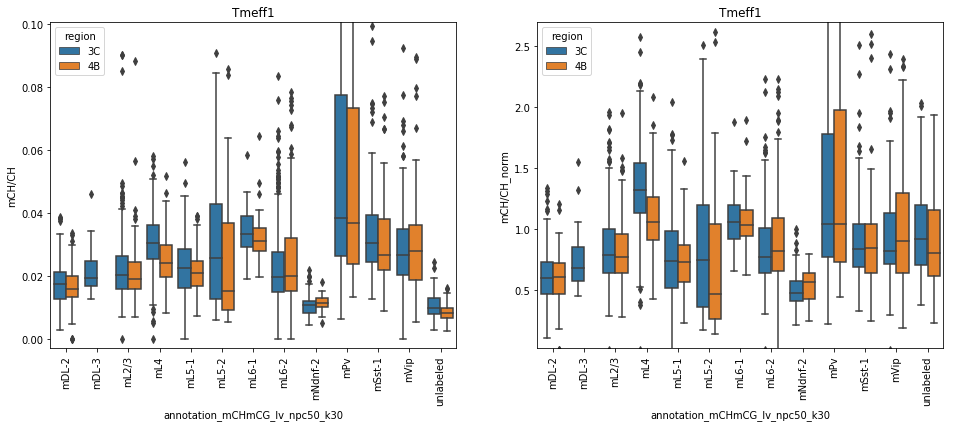

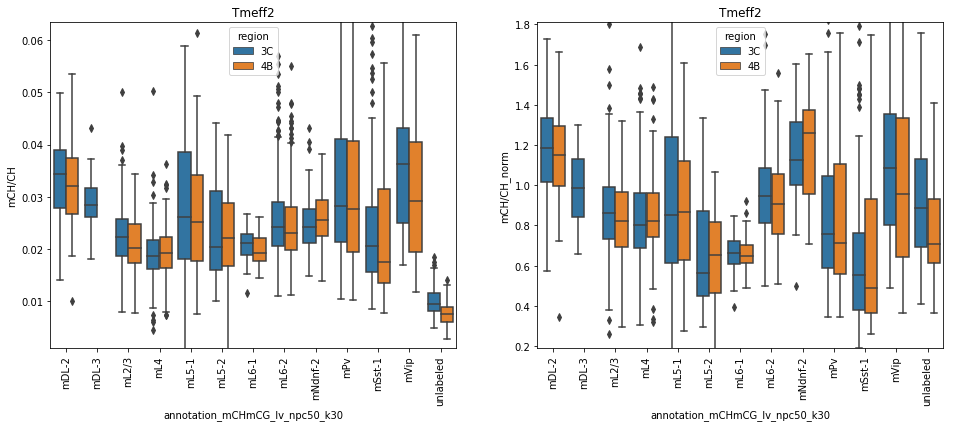

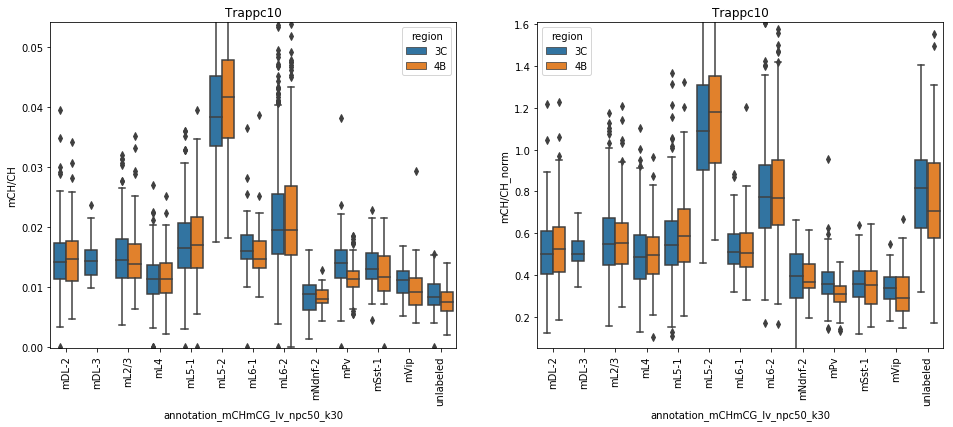

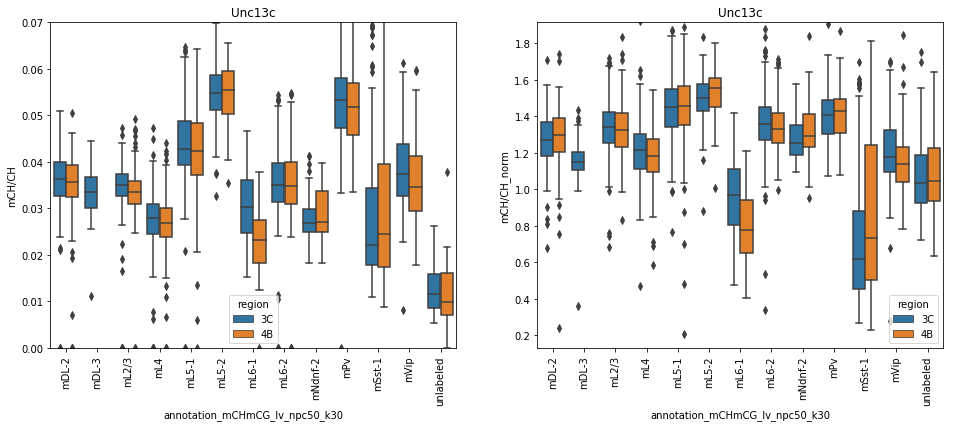

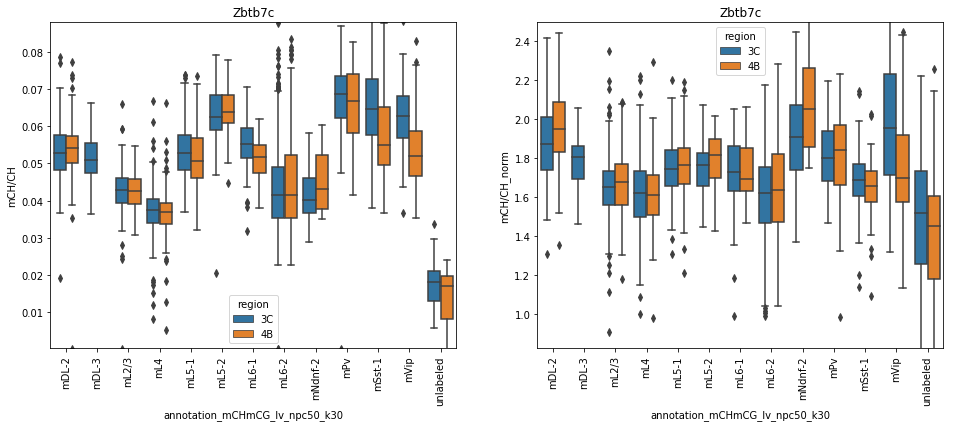

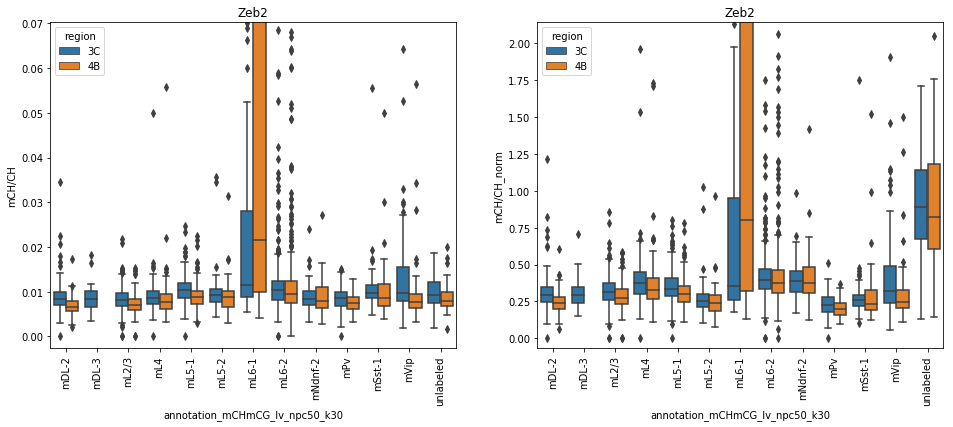

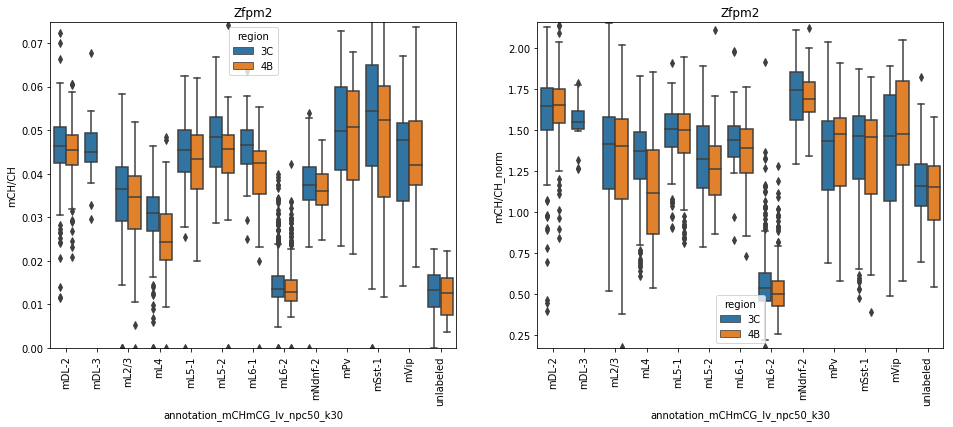

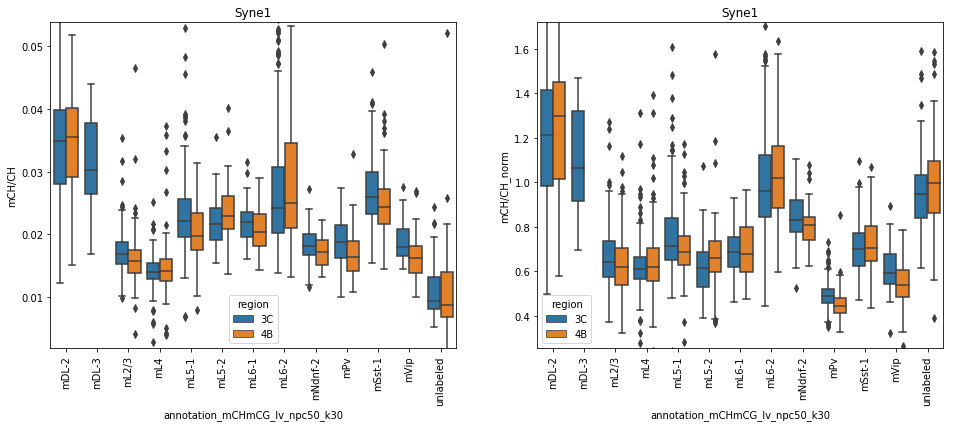

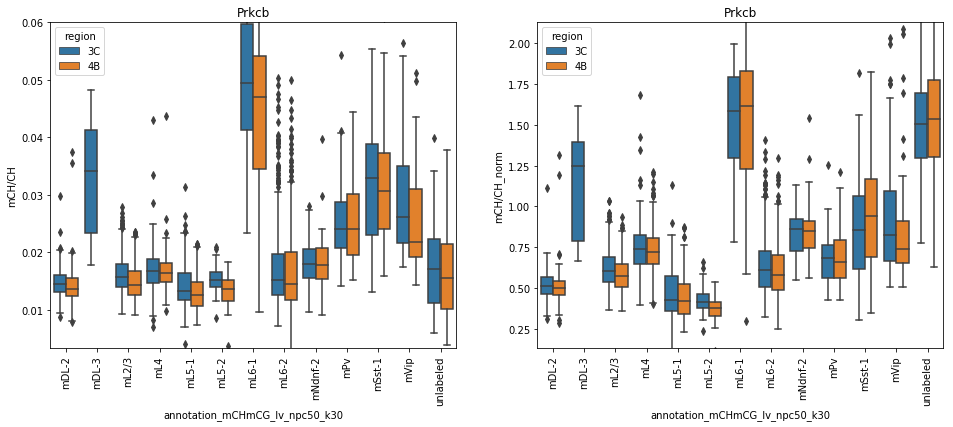

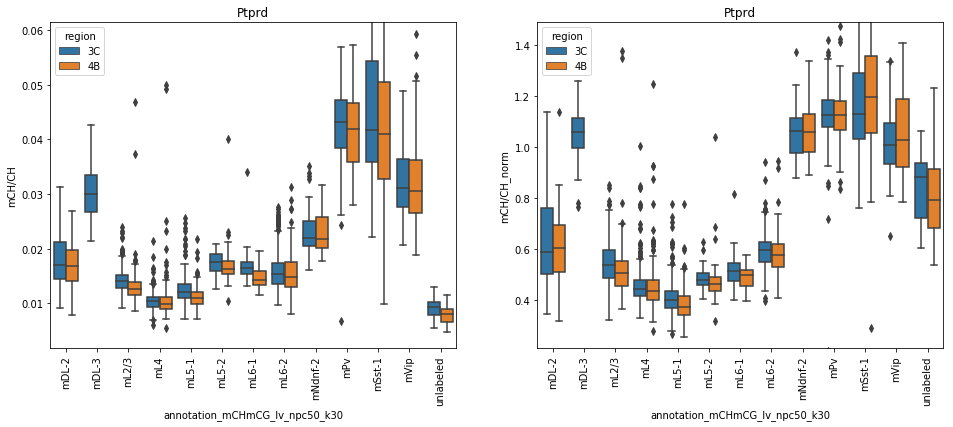

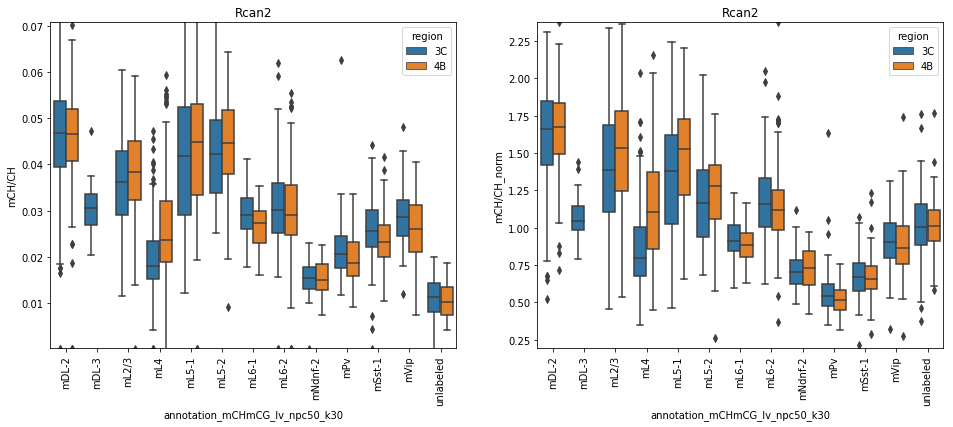

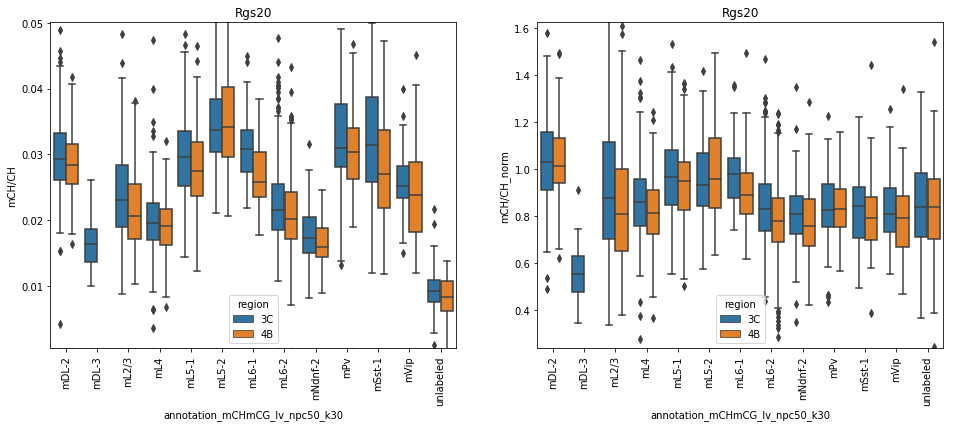

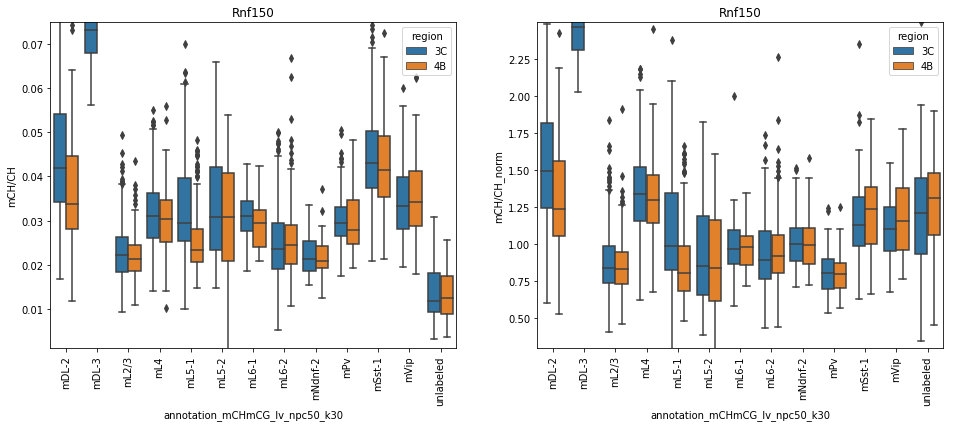

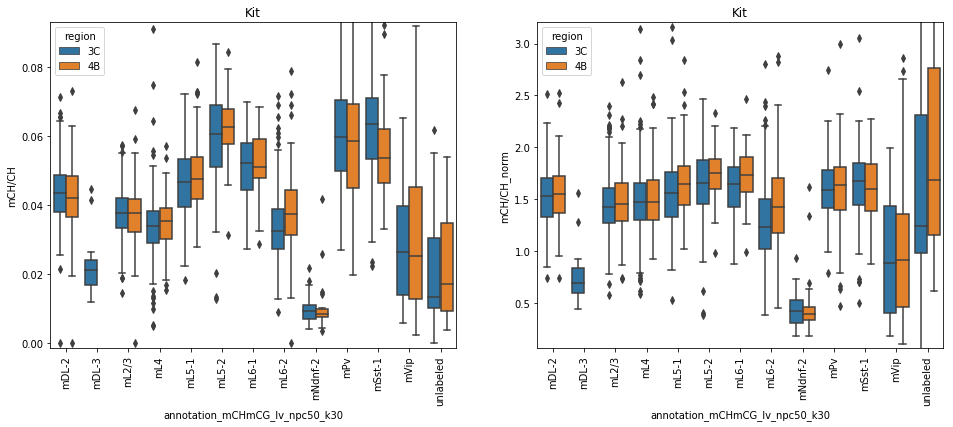

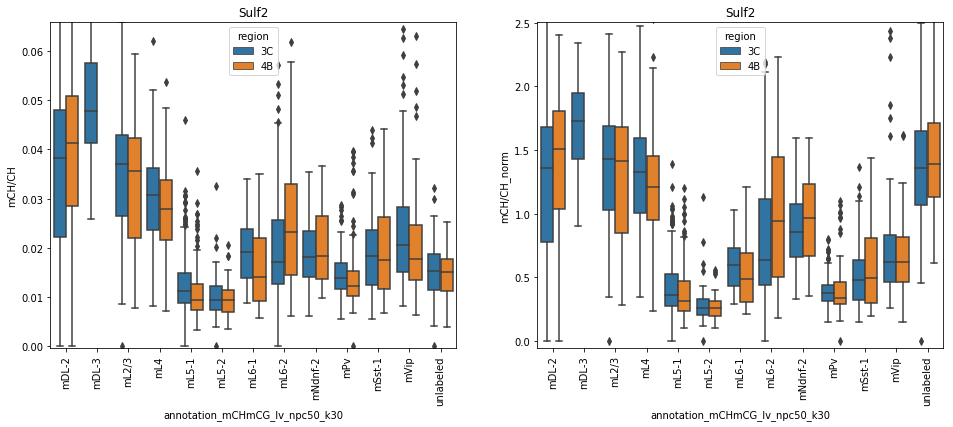

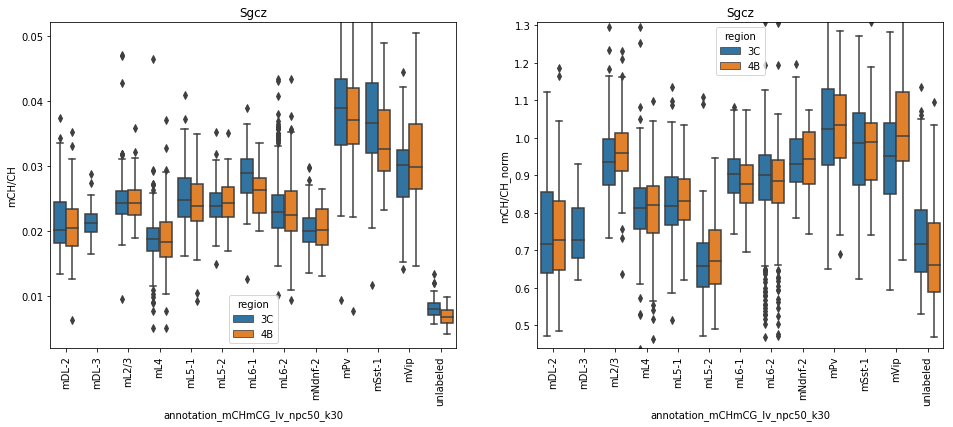

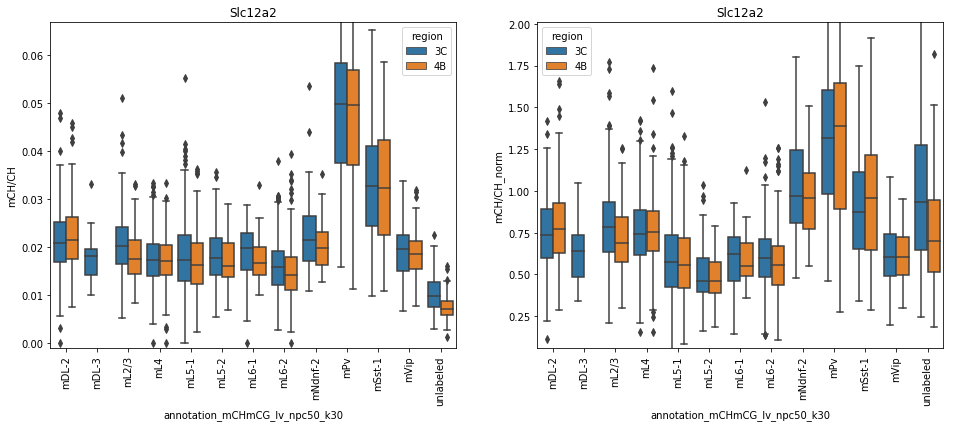

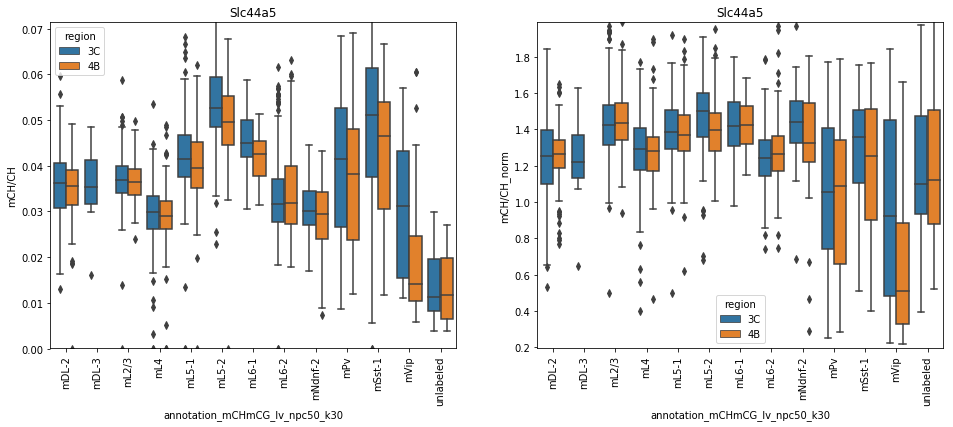

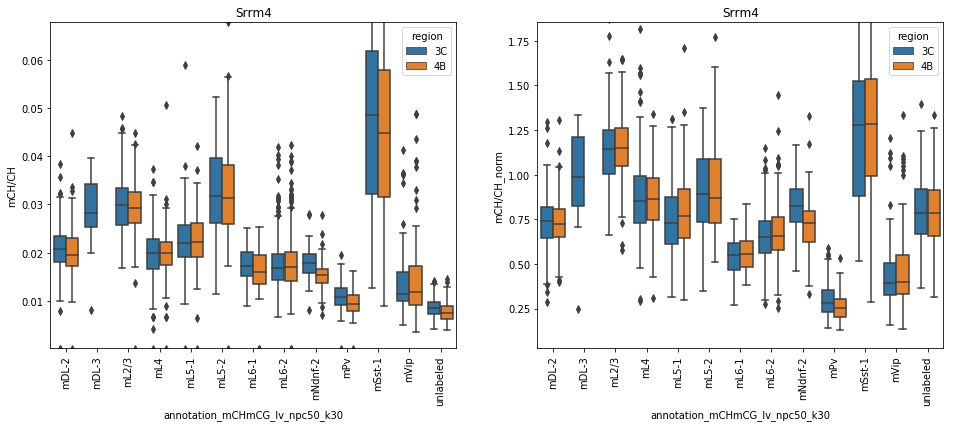

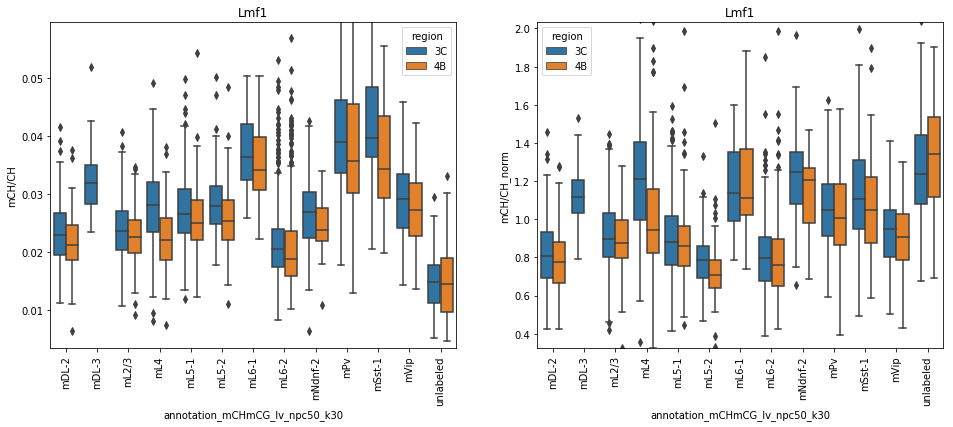

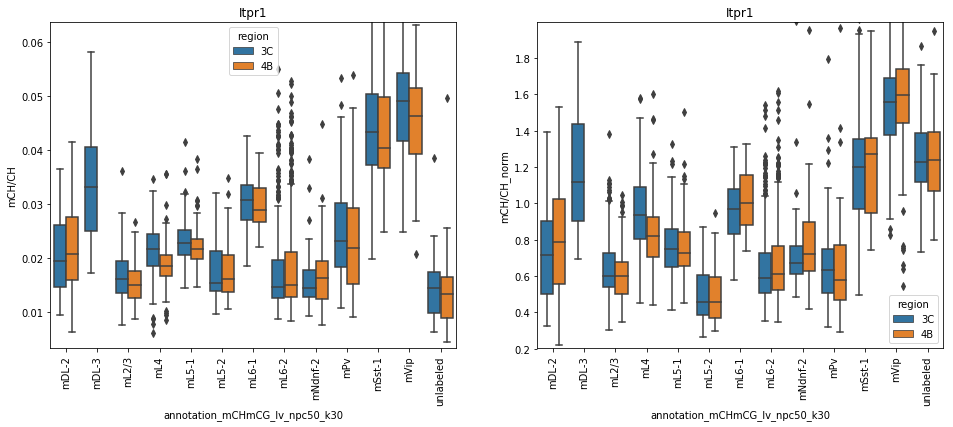

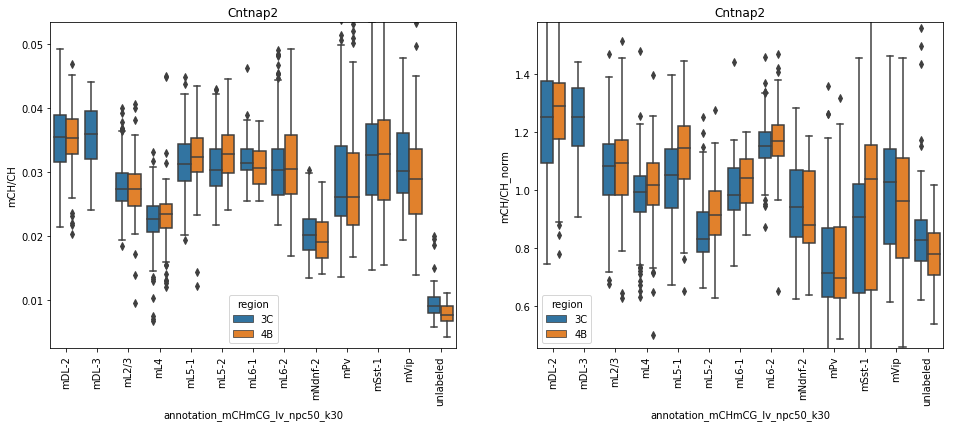

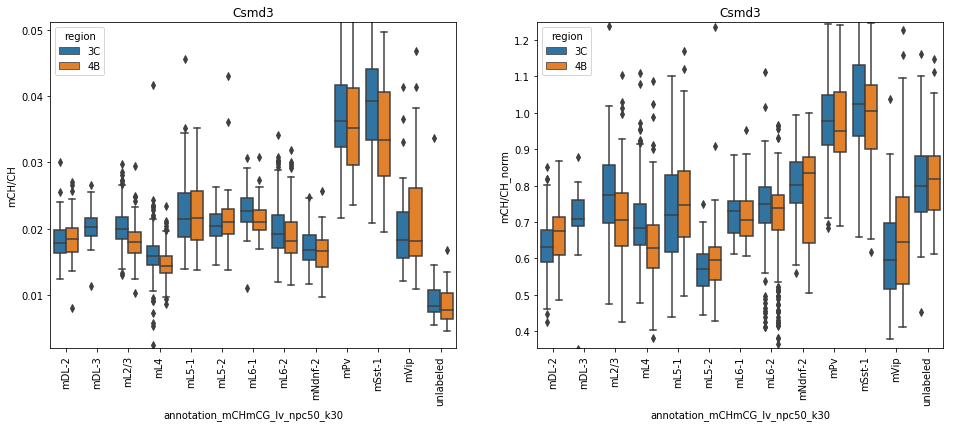

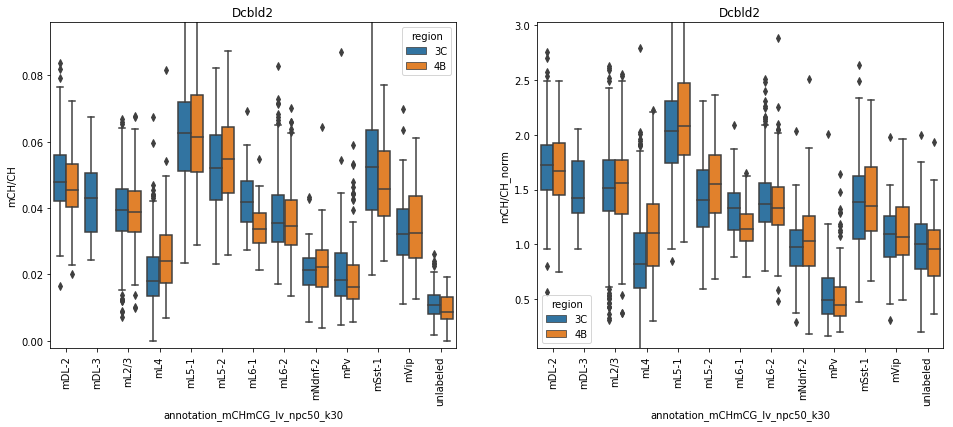

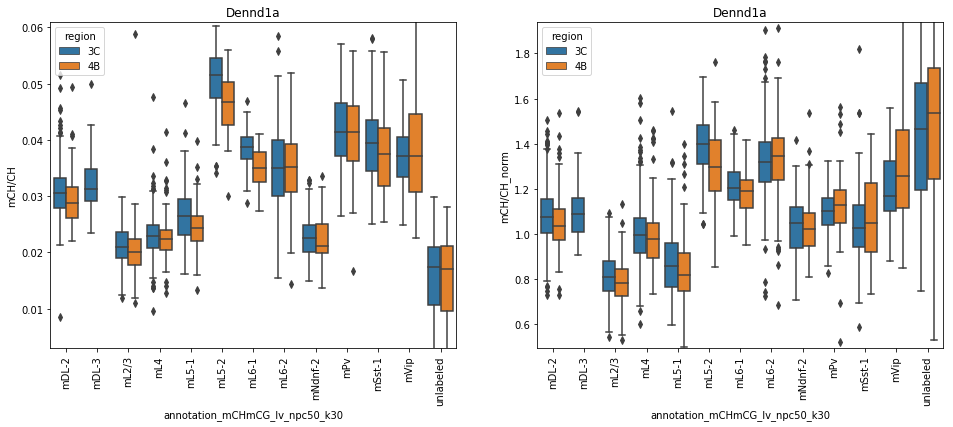

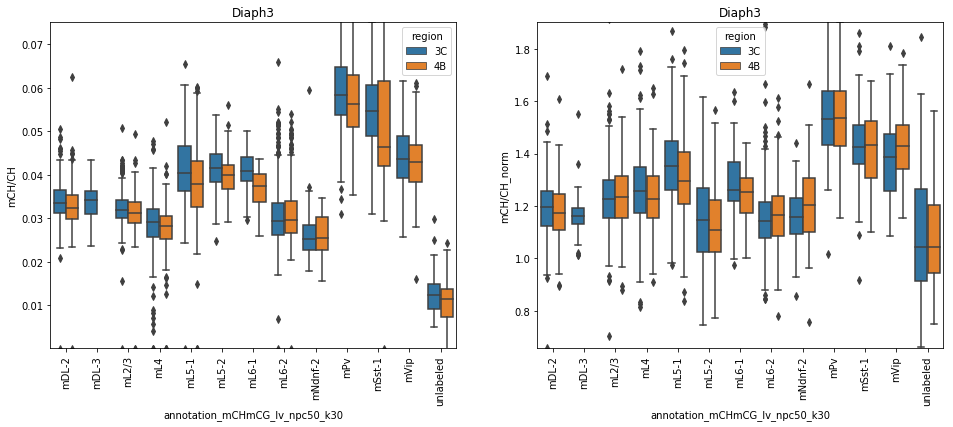

In [40]:
# Look at those genes in detail
# boxplot 3C vs 4B




for gene_name in top_genes_stats[top_genes_stats['mCH_range'] > 0.04].gene_name[:50]:
    gene_id = df_gene[df_gene.gene_name==gene_name].index.values[0]
    gene_table = id2table(gene_id)
    sql = """SELECT cell_name, mCH, CH, global_mCH, dataset, {}, {}
            FROM {} 
            JOIN cells 
            ON {}.cell_id = cells.cell_id
            JOIN {}
            ON {}.cell_id = cells.cell_id""".format(cluster_col, annot_col, gene_table, gene_table, ens, ens)
    dfg = pd.read_sql(sql, engine)
    dfg['mCH/CH'] = dfg.mCH/dfg.CH
    dfg['mCH/CH_norm'] = dfg['mCH/CH']/dfg['global_mCH']
    dfg['region'] = [dataset[len('CEMBA_'):-len('_171206')] for dataset in dfg['dataset']]
    dfg[annot_col] = dfg[annot_col].fillna('unlabeled')
    order = sorted(dfg[annot_col].unique().tolist())
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    ax = axs[0]
    sns.boxplot(x=annot_col, y='mCH/CH', hue='region', order=order, data=dfg, ax=ax)
    yrange = [np.nanpercentile(dfg['mCH/CH'].values, 1), np.nanpercentile(dfg['mCH/CH'].values, 99)]
    yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(gene_name)
    
    ax = axs[1]
    sns.boxplot(x=annot_col, y='mCH/CH_norm', hue='region', order=order, data=dfg, ax=ax)
    yrange = [np.nanpercentile(dfg['mCH/CH_norm'].values, 1), np.nanpercentile(dfg['mCH/CH_norm'].values, 99)]
    yrange[0] = yrange[0] - 0.1*(yrange[1] - yrange[0])
    yrange[1] = yrange[1] + 0.1*(yrange[1] - yrange[0])
    ax.set_ylim(yrange)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_title(gene_name)
    plt.show()
    
# tune visualization

In [41]:
# f1_macros of hDL-1, hL6-2 are due to skewed dataset (low MB_EA)
df_info.groupby(['cluster_annotation', 'Biosample'])['mCH/CH', 'mCG/CG'].count()

KeyError: "Columns not found: 'mCG/CG'"

# ICA marker genes (see if the lists converge)

1. run PCA, reduce dimensions of feature space (genes)

2. run ICA in PC spaces

3. identify certain interesting ICs
    - plot ICs against each other

    - plot IC on tSNE

4. Plot IC coefficients, look at top genes



In [ ]:

cell_types_tr2 = sr_n_tr.index.values
# for celltype in cell_types_tr2:
celltype = 'mSst-1'
df_xy0, df_xy1 = get_data(celltype)
df_x = df_xy1.filter(regex='^ENS')

df_x.head
print(df_x.shape)

In [ ]:
# ICA workflow

n_comp = 10
# fit PCA
pca = PCA(n_components=n_comp).fit(df_x)
pcs = pca.transform(df_x)

df_pc_axis = pd.DataFrame(pca.components_, 
                       index=['PC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

df_pc_axis.head()


In [ ]:
# visualize PCA
# np.cov(pcs.T)
# np.diag(np.cov(pcs.T).diagonal())



In [ ]:
# ICA after PCA and reconstruct data
# manual whitening
C = np.sqrt(np.diag(np.cov(pcs.T).diagonal()))
pcsw = np.dot(pcs, np.linalg.inv(C))
# check if whitened
# print(np.cov(pcsw.T))

# fit ICA
ica = FastICA(whiten=False).fit(pcsw)
ics = ica.transform(pcsw)
df_ics = pd.DataFrame(ics, columns=['IC'+str(i+1) for i in range(n_comp)], index=df_x.index)

axis = np.dot(np.dot(ica.components_, C), pca.components_)
df_ic_axis = pd.DataFrame(axis, 
                       index=['IC' + str(i+1) for i in range(n_comp)], 
                       columns=df_x.columns)

In [ ]:
# plot ICs

df_plot_ics = pd.merge(df_ics, df_info, left_index=True, right_index=True)
print(df_plot_ics.shape)

g = sns.pairplot(df_plot_ics[df_ics.columns.tolist() + ['Biosample']], hue='Biosample', 
                 diag_kind='kde', markers='o', size=2.5)
# print(g.axes.shape)
# for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
#     g.axes[i, j].set_visible(False)
plt.show()

In [ ]:
# plot IC tsne
plot_tsne_values(df_plot_ics, tx=tsne_cols[0], ty=tsne_cols[1], tc='IC1')

In [ ]:
# 
# look at IC1 (which seperates MB_EA from other biosamples)

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
icc = df_ic_axis.loc['IC1', :].apply(np.abs).sort_values(ascending=False)
ax = axs[0]
ax.plot(icc.values, 'o-')
ax = axs[1]
ax.plot(icc.values[:100], 'o-')
ax = axs[2]
ax.plot(icc.values[:10], 'o-')
fig.tight_layout()
plt.show()

In [ ]:
# what are those genes
n_top = 30
sr_top_genes_2 = df_gene.loc[icc.index.values[:n_top], 'geneName']
sr_top_genes_2.to_frame()

In [ ]:
# tsne_box plot

for gene_id, gene_name in sr_top_genes_2.iteritems():
    df_plot = pd.merge(df_info, df_xy[[gene_id]], left_index=True, right_index=True) 
    tsne_and_boxplot(df_plot, tc=gene_id, bx='Biosample', by=gene_id,
                    output=None, show=True, close=False, 
                    title=('Genebody mCH: %s' % gene_name), 
                    figsize=(6,8),
                    t_xlim=None, t_ylim=None, b_xlim=None, b_ylim=None, 
                    low_p=5, hi_p=95)

In [ ]:
# those that are in list 1 but not in 2 may be genes that separates bewteen MB_v1 and MB_EB

In [ ]:
# compare LDA with top ANOVA genes and LDA with random genes

In [ ]:
# find an index that show "exci v.s. inhi variance difference"

# eta-squared distribution for effect size

# if ANOVA for PV cells are skewed by few cells in MB_EB

In [ ]:
# run exactly the same analysis with mCG